In [1]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import time
import multiprocessing as mp
import sys
import dataAck
import curveTreeDB

def getValidModelsByTicker(db, ticker):
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=db)
            
            query.add_filter("ticker", '=', ticker)
            query.add_filter("IS_SHARPE DIFFERENCE SLIPPAGE", '>', 0.0)
            retrievedModels = list(query.fetch())
            return retrievedModels
        except:
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))
            return 


In [153]:
import params
import curveTreeDB
allModels = curveTreeDB.getValidModels(params.treeModels, returnEntireObject = True)

In [31]:
allValidModels = getValidModelsByTicker(params.treeModels, "USO")
# allValidModels = curveTreeDB.getValidModels(params.treeModels, returnEntireObject = True)

In [108]:
def getPertinentDataModels(db):
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=db)
#             query.add_filter("numberOfPredictors", "=", 2)
            query.add_filter("IS_PROFITABILITY DIFFERENCE", '>', 0.02)
            retrievedModels = list(query.fetch())
            return retrievedModels
        except:
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))
            return 

In [109]:
allValidModels = getPertinentDataModels(params.averageTreeModels)

In [110]:
quickModels = []
predLength = {}
for mod in allValidModels:
#     if mod["predictionLength"] < 10:
#         continue
    if mod["predictionLength"] not in predLength:
        predLength[mod["predictionLength"]] = []
    predLength[mod["predictionLength"]].append(abs(mod["OOS_BETA"] - mod["IS_BETA"]))
#     print(mod["IS_BETA"], mod["OOS_BETA"], mod["predictionLength"])
    quickModels.append(mod)

# for item in sorted(predLength):
#     print(item, sum(predLength[item])/len(predLength[item]))

In [111]:
len(quickModels)

1353

In [112]:
import pandas as pd
cleanedModels = []
seenTickers = {}
seenPredictors = {}
tickerSharpe = {}

for item in quickModels:
#     del item["model"]
#     try:
#         del item["series"]
#     except:
#         pass
#     try:
#         print(item["IS_PROFITABILITY"], item["lastXDays"], item["IS_BETA"], item["OOS_BETA"])
#     except:
#         continue
#     if item["IS_SHARPE DIFFERENCE SLIPPAGE"] < 0.0:
#         continue
    
#     del item["ticker"]
    if item["IS_PROFITABILITY"] < 0.51:# or item["IS_BETA"] > 0.1:# or item["IS_ACTIVITY"] < 0.6 or item["IS_SHARPE"] < 1.0 or item["IS_PROFITABILITY"] < 0.45:
        continue
    
    
    if item["numberOfPredictors"] not in seenPredictors:
        seenPredictors[item["numberOfPredictors"]] = {"better":0, "greaterThanZero":0, "bad":0, "total":0}
    
    seenPredictors[item["numberOfPredictors"]]["total"] += 1
    if item["OOS_SHARPE"] > item["OOS_FACTOR SHARPE"]:
#         print(item["ticker"], item["OOS_SHARPE"], item["OOS_FACTOR SHARPE"] )
        seenPredictors[item["numberOfPredictors"]]["better"] += 1
    if item["OOS_SHARPE"] > 0:
        seenPredictors[item["numberOfPredictors"]]["greaterThanZero"] += 1
        print("SHARPE", item["IS_SHARPE"], item["OOS_SHARPE"], item["OOS_FACTOR SHARPE"])
        print("RAW BETA", item["IS_RAW BETA"], item["OOS_RAW BETA"])
        print("BETA", item["IS_BETA"], item["OOS_BETA"])
        print("**********")
    if item["OOS_SHARPE"] < 0 and item["OOS_FACTOR SHARPE"] > 0:
        seenPredictors[item["numberOfPredictors"]]["bad"] += 1
        
        
    if item["ticker"] not in seenTickers:
        seenTickers[item["ticker"]] = 0
    if item["ticker"] not in tickerSharpe:
        tickerSharpe[item["ticker"]] = item["OOS_FACTOR SHARPE"]
    seenTickers[item["ticker"]] += 1
    itemKeys= list(item.keys())
    for key in itemKeys:
        if key.startswith("OOS") and key != "OOS_FACTOR SHARPE" and key != "OOS_RAW BETA" and key != "OOS_PROFITABILITY" and key != "OOS_SHARPE DIFFERENCE SLIPPAGE" and key != "OOS_SHARPE" and key != "OOS_BETA" and key != "OOS_ANNUALIZED RETURN":
            del item[key]
    cleanedModels.append(item)
print(seenTickers)
print(tickerSharpe)
for predictors in sorted(seenPredictors):
    print(predictors, seenPredictors[predictors]["total"],\
          1.0 - seenPredictors[predictors]["bad"]/seenPredictors[predictors]["total"],\
          seenPredictors[predictors]["better"]/seenPredictors[predictors]["total"],\
          seenPredictors[predictors]["greaterThanZero"]/seenPredictors[predictors]["total"])
    
    
    
    
    

SHARPE 1.1476481077941276 0.25325296966224514 -0.4863072178308576
RAW BETA 0.04799763188438378 0.2295433070866148
BETA 0.019392544806964014 0.04975040256718597
**********
SHARPE 0.9340939743450073 0.6159466824301679 1.2500356124067282
RAW BETA 0.22628934614781485 0.1954545454545445
BETA 0.05122455574162807 0.0021545572166124494
**********
SHARPE 0.6203207308008083 1.3241620335998636 1.2016036851037413
RAW BETA 0.2103263411948326 0.5055537924468434
BETA 0.027557975870138796 0.18100452351502078
**********
SHARPE 1.1238570966726962 0.1568249956905457 0.48363230349410347
RAW BETA 0.06921446715130955 0.25454545454545424
BETA 0.02016766469780613 0.06339801943674277
**********
SHARPE 0.4598682999689935 0.7378856325822517 0.6628499047737775
RAW BETA 0.027610006606721797 0.11088709677419337
BETA 0.010000951123052104 0.028052123305756075
**********
SHARPE 0.7594913885206536 0.014396285458221839 -0.9242590389262009
RAW BETA 0.11435175894337084 0.37516005121638946
BETA 0.06358940225821105 0.168815

In [113]:
len(cleanedModels)

1352

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_PROFITABILITY


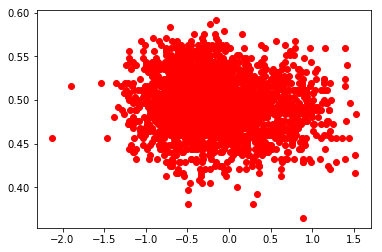

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_SHARPE DIFFERENCE SLIPPAGE


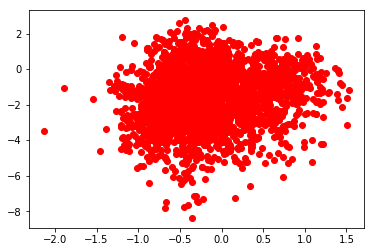

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_SHARPE


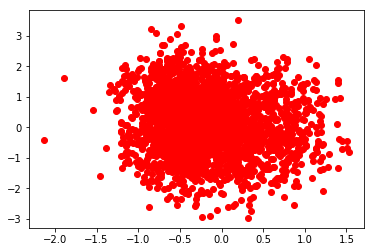

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_BETA


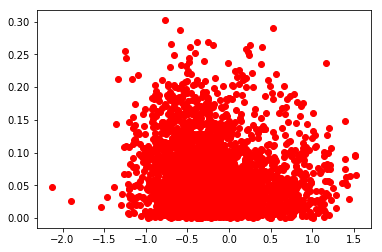

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_ANNUALIZED RETURN


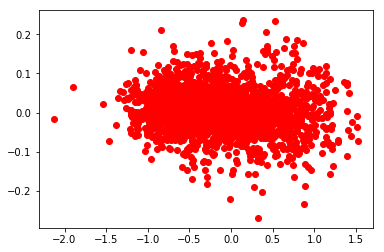

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_FACTOR SHARPE


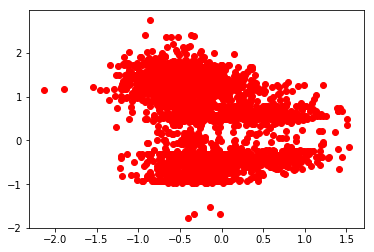

IS_25TH PERCENTILE SHARPE OOS_PROFITABILITY


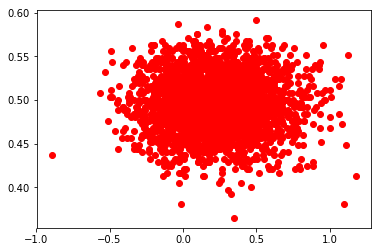

IS_25TH PERCENTILE SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


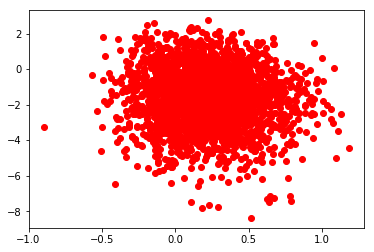

IS_25TH PERCENTILE SHARPE OOS_SHARPE


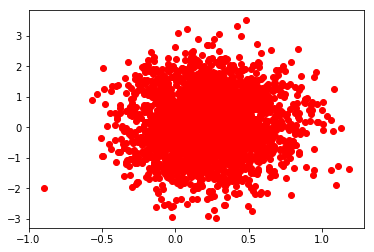

IS_25TH PERCENTILE SHARPE OOS_BETA


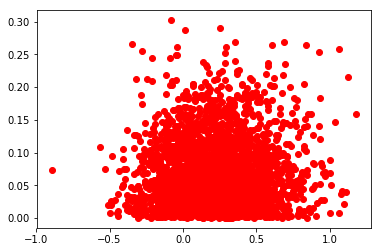

IS_25TH PERCENTILE SHARPE OOS_ANNUALIZED RETURN


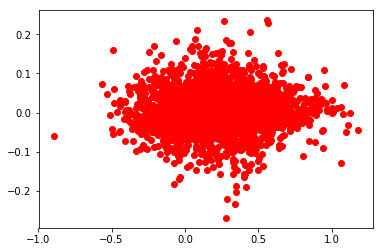

IS_25TH PERCENTILE SHARPE OOS_FACTOR SHARPE


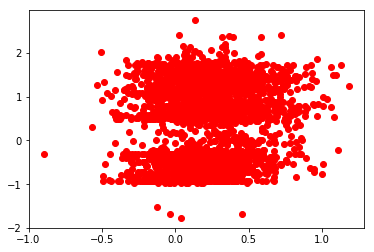

IS_25TH PERCENTILE SHARPE 45 OOS_PROFITABILITY


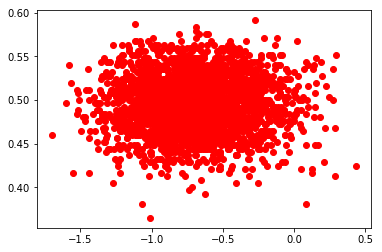

IS_25TH PERCENTILE SHARPE 45 OOS_SHARPE DIFFERENCE SLIPPAGE


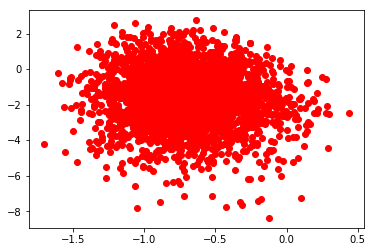

IS_25TH PERCENTILE SHARPE 45 OOS_SHARPE


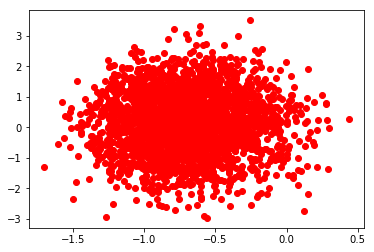

IS_25TH PERCENTILE SHARPE 45 OOS_BETA


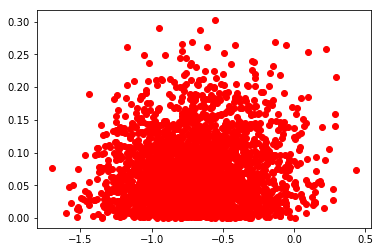

IS_25TH PERCENTILE SHARPE 45 OOS_ANNUALIZED RETURN


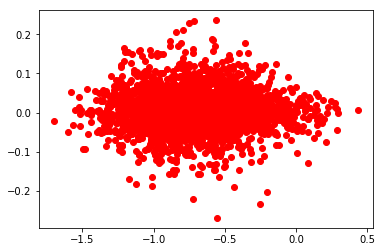

IS_25TH PERCENTILE SHARPE 45 OOS_FACTOR SHARPE


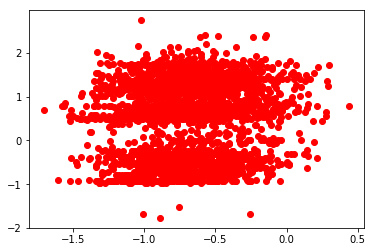

IS_25TH PERCENTILE SHARPE 90 OOS_PROFITABILITY


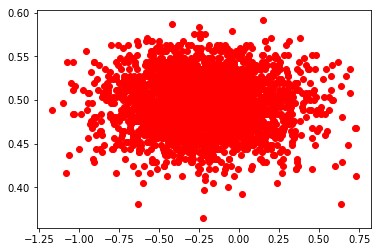

IS_25TH PERCENTILE SHARPE 90 OOS_SHARPE DIFFERENCE SLIPPAGE


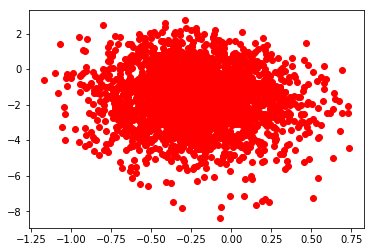

IS_25TH PERCENTILE SHARPE 90 OOS_SHARPE


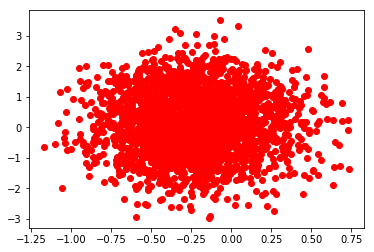

IS_25TH PERCENTILE SHARPE 90 OOS_BETA


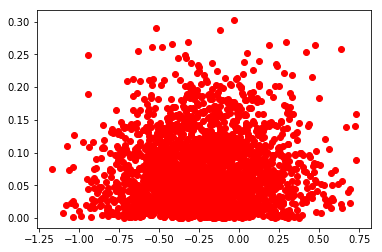

IS_25TH PERCENTILE SHARPE 90 OOS_ANNUALIZED RETURN


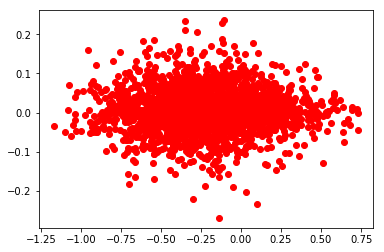

IS_25TH PERCENTILE SHARPE 90 OOS_FACTOR SHARPE


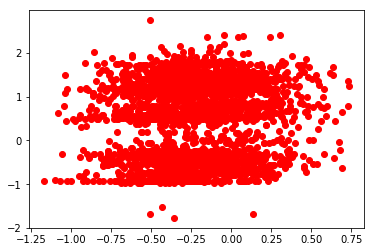

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_PROFITABILITY


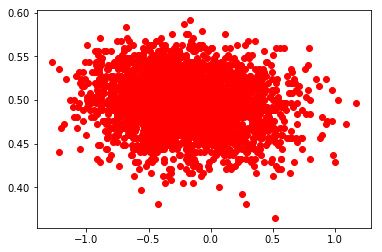

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_SHARPE DIFFERENCE SLIPPAGE


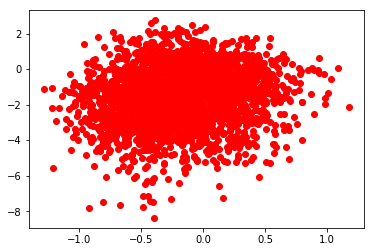

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_SHARPE


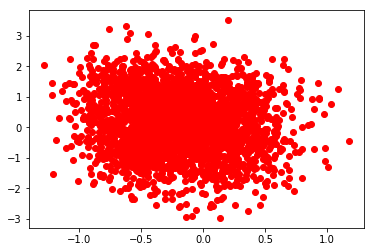

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_BETA


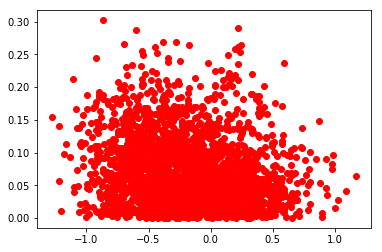

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_ANNUALIZED RETURN


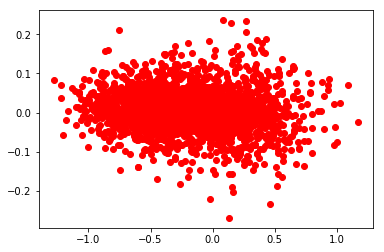

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_FACTOR SHARPE


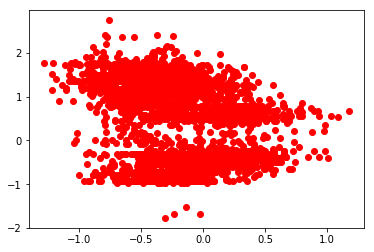

IS_25TH PROFITABILITY 45
0.444444    0.490789
0.450000    0.503968
0.461111    0.464286
0.466667    0.494832
0.472222    0.503968
0.483333    0.500000
0.488889    0.498973
0.494444    0.535714
0.511111    0.511042
Name: OOS_PROFITABILITY, dtype: float64
IS_25TH PROFITABILITY 45
0.444444   -1.337341
0.450000    0.043828
0.461111   -4.323886
0.466667   -1.583714
0.472222   -2.029269
0.483333   -2.177874
0.488889   -1.841280
0.494444   -2.458396
0.511111   -2.231544
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
IS_25TH PROFITABILITY 45
0.444444    0.134359
0.450000    0.391386
0.461111   -0.167176
0.466667    0.129356
0.472222    0.489629
0.483333   -0.453841
0.488889    0.168151
0.494444    0.784913
0.511111    0.424798
Name: OOS_SHARPE, dtype: float64
IS_25TH PROFITABILITY 45 OOS_PROFITABILITY


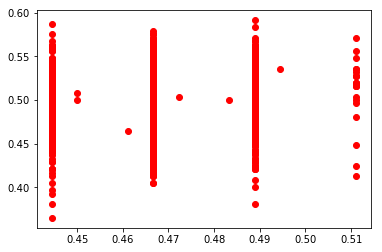

IS_25TH PROFITABILITY 45 OOS_SHARPE DIFFERENCE SLIPPAGE


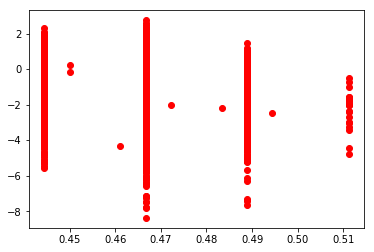

IS_25TH PROFITABILITY 45 OOS_SHARPE


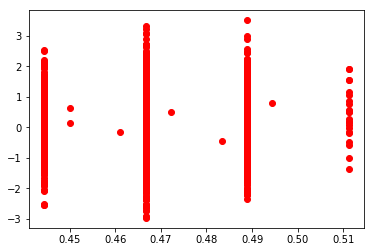

IS_25TH PROFITABILITY 45 OOS_BETA


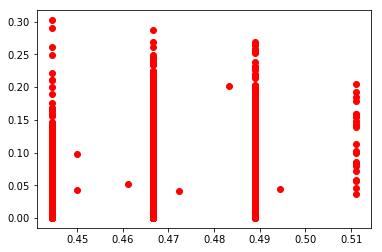

IS_25TH PROFITABILITY 45 OOS_ANNUALIZED RETURN


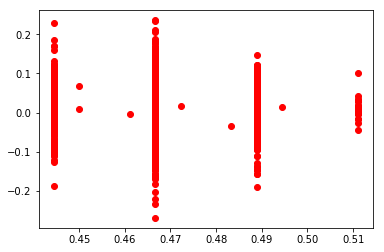

IS_25TH PROFITABILITY 45 OOS_FACTOR SHARPE


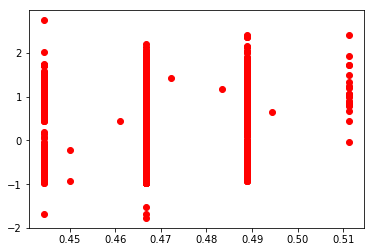

IS_25TH PROFITABILITY 90
0.450000    0.567460
0.455556    0.489203
0.466667    0.491074
0.469444    0.476190
0.472222    0.484127
0.475000    0.464286
0.477778    0.494483
0.483333    0.484127
0.486111    0.484127
0.488889    0.494894
0.491667    0.496032
0.494444    0.519841
0.497222    0.539683
0.500000    0.501015
0.505556    0.527778
0.508333    0.472222
0.511111    0.506531
0.522222    0.514430
Name: OOS_PROFITABILITY, dtype: float64
IS_25TH PROFITABILITY 90
0.450000    0.812366
0.455556   -0.883884
0.466667   -1.327060
0.469444   -2.143463
0.472222   -1.401502
0.475000   -1.147527
0.477778   -1.592777
0.483333   -2.672055
0.486111   -1.231738
0.488889   -1.697482
0.491667    0.246175
0.494444   -3.931457
0.497222   -1.397805
0.500000   -1.773412
0.505556   -2.515801
0.508333   -3.849347
0.511111   -1.997515
0.522222   -2.446333
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
IS_25TH PROFITABILITY 90
0.450000    2.132802
0.455556    0.132421
0.466667    0.137767
0.469444   -0

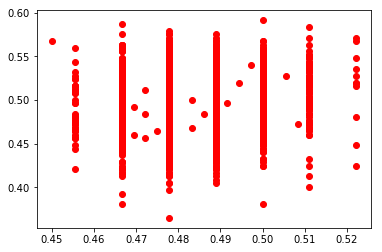

IS_25TH PROFITABILITY 90 OOS_SHARPE DIFFERENCE SLIPPAGE


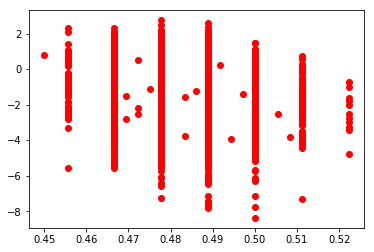

IS_25TH PROFITABILITY 90 OOS_SHARPE


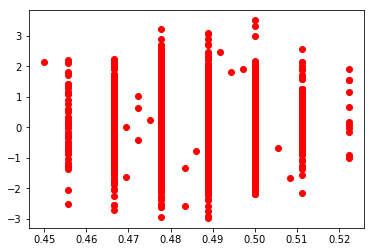

IS_25TH PROFITABILITY 90 OOS_BETA


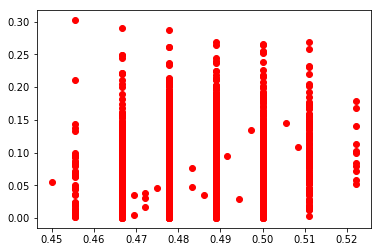

IS_25TH PROFITABILITY 90 OOS_ANNUALIZED RETURN


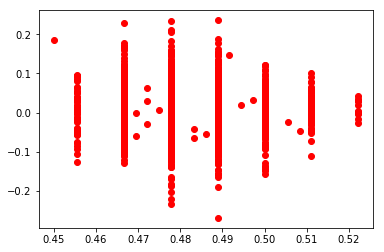

IS_25TH PROFITABILITY 90 OOS_FACTOR SHARPE


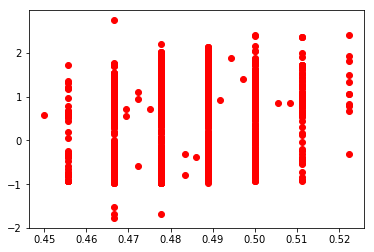

IS_ACTIVE PROFITABILITY OOS_PROFITABILITY


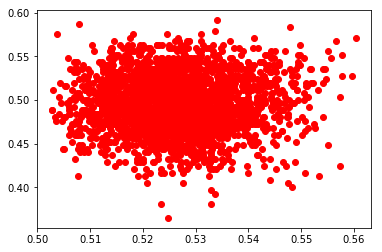

IS_ACTIVE PROFITABILITY OOS_SHARPE DIFFERENCE SLIPPAGE


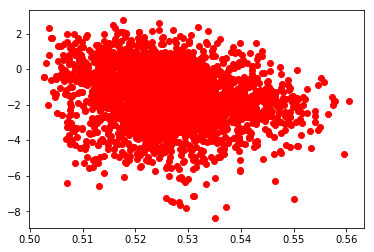

IS_ACTIVE PROFITABILITY OOS_SHARPE


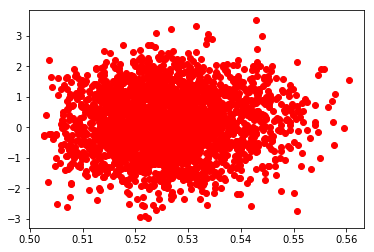

IS_ACTIVE PROFITABILITY OOS_BETA


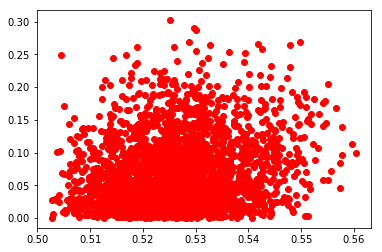

IS_ACTIVE PROFITABILITY OOS_ANNUALIZED RETURN


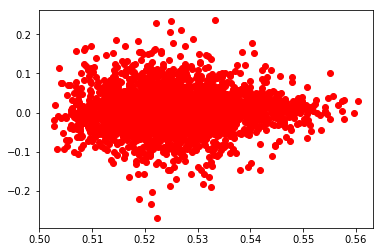

IS_ACTIVE PROFITABILITY OOS_FACTOR SHARPE


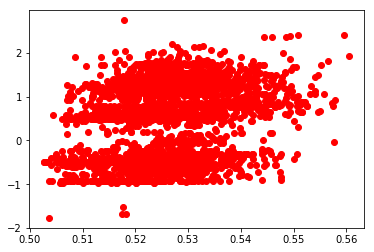

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_PROFITABILITY


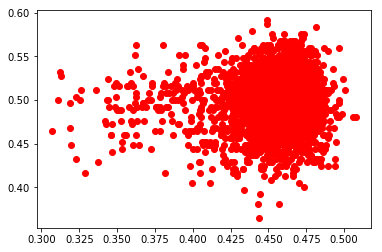

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_SHARPE DIFFERENCE SLIPPAGE


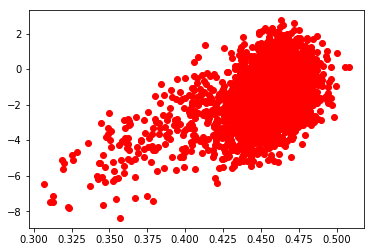

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_SHARPE


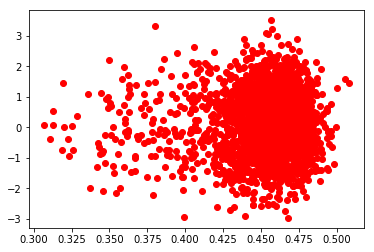

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_BETA


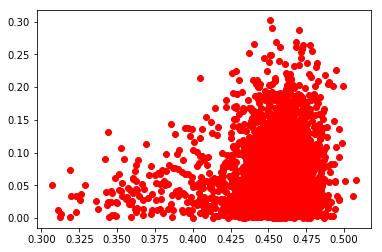

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_ANNUALIZED RETURN


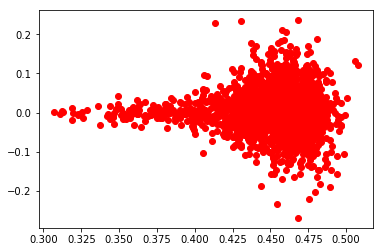

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_FACTOR SHARPE


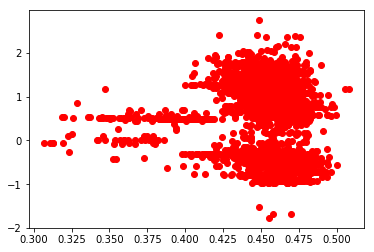

IS_ACTIVITY OOS_PROFITABILITY


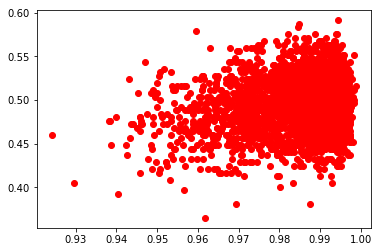

IS_ACTIVITY OOS_SHARPE DIFFERENCE SLIPPAGE


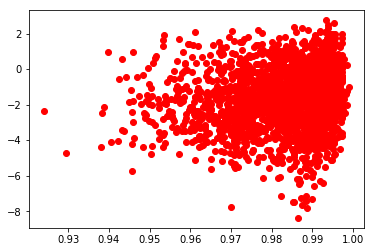

IS_ACTIVITY OOS_SHARPE


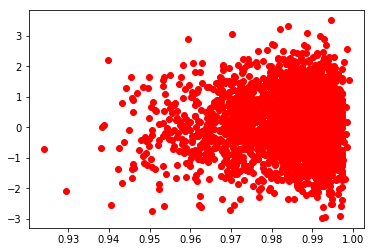

IS_ACTIVITY OOS_BETA


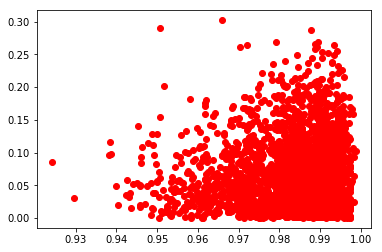

IS_ACTIVITY OOS_ANNUALIZED RETURN


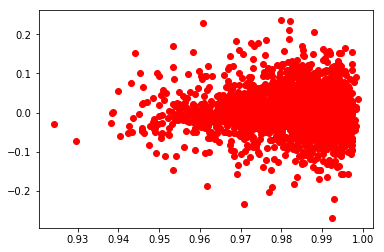

IS_ACTIVITY OOS_FACTOR SHARPE


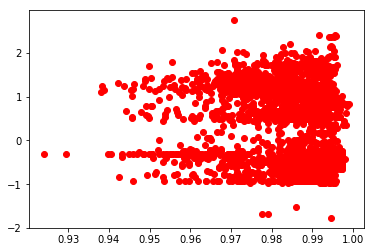

IS_ALPHA OOS_PROFITABILITY


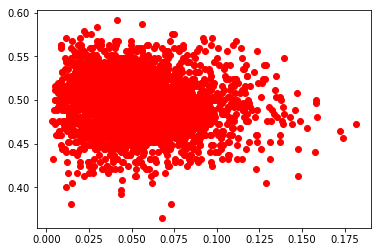

IS_ALPHA OOS_SHARPE DIFFERENCE SLIPPAGE


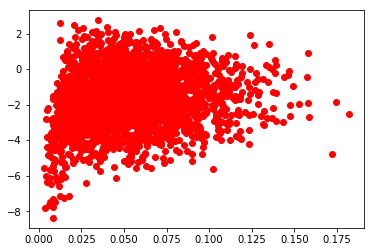

IS_ALPHA OOS_SHARPE


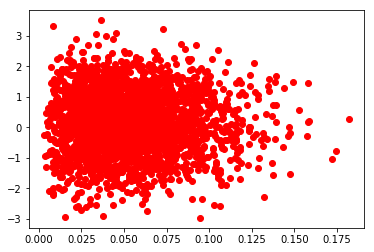

IS_ALPHA OOS_BETA


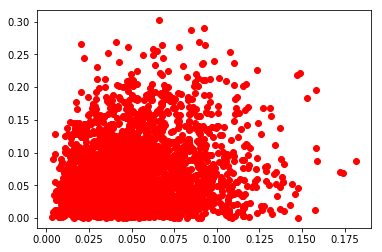

IS_ALPHA OOS_ANNUALIZED RETURN


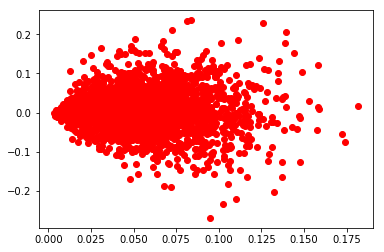

IS_ALPHA OOS_FACTOR SHARPE


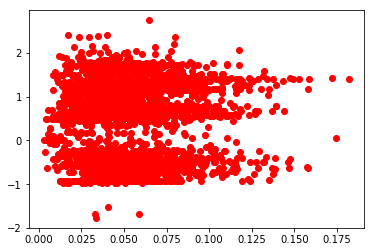

IS_ALPHA SLIPPAGE OOS_PROFITABILITY


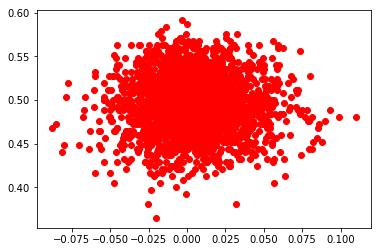

IS_ALPHA SLIPPAGE OOS_SHARPE DIFFERENCE SLIPPAGE


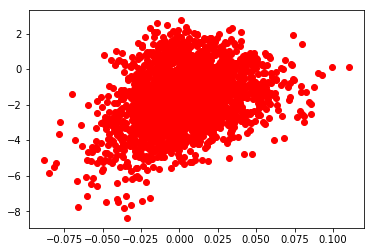

IS_ALPHA SLIPPAGE OOS_SHARPE


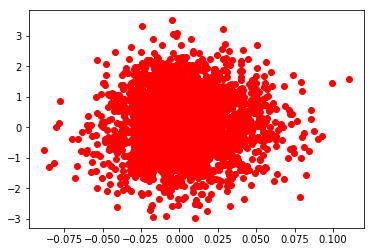

IS_ALPHA SLIPPAGE OOS_BETA


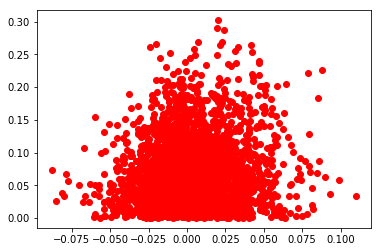

IS_ALPHA SLIPPAGE OOS_ANNUALIZED RETURN


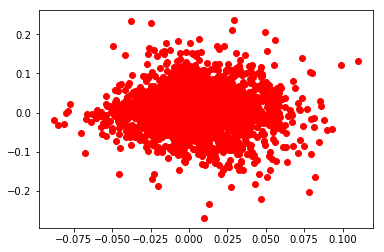

IS_ALPHA SLIPPAGE OOS_FACTOR SHARPE


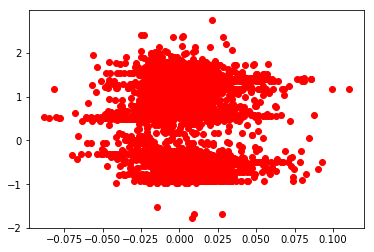

IS_ANNUALIZED RETURN OOS_PROFITABILITY


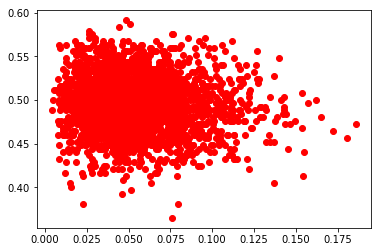

IS_ANNUALIZED RETURN OOS_SHARPE DIFFERENCE SLIPPAGE


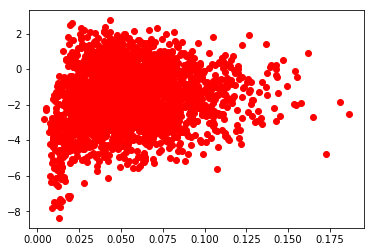

IS_ANNUALIZED RETURN OOS_SHARPE


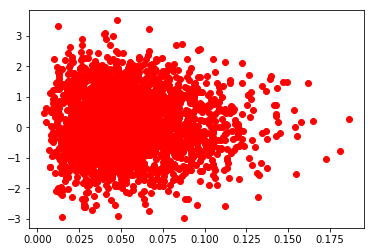

IS_ANNUALIZED RETURN OOS_BETA


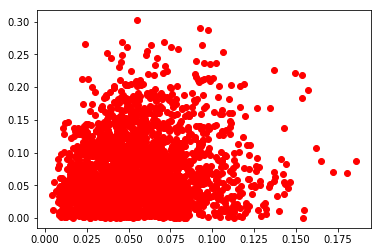

IS_ANNUALIZED RETURN OOS_ANNUALIZED RETURN


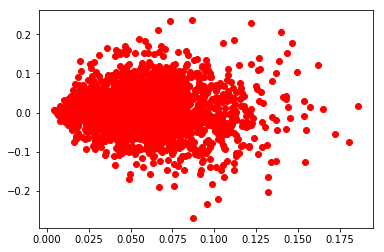

IS_ANNUALIZED RETURN OOS_FACTOR SHARPE


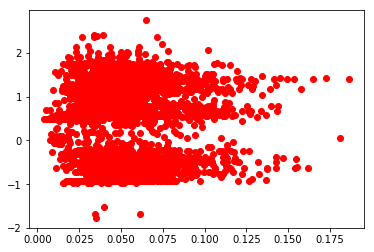

IS_BETA OOS_PROFITABILITY


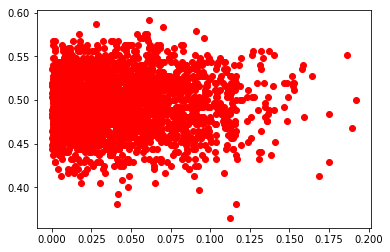

IS_BETA OOS_SHARPE DIFFERENCE SLIPPAGE


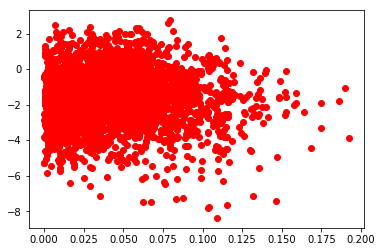

IS_BETA OOS_SHARPE


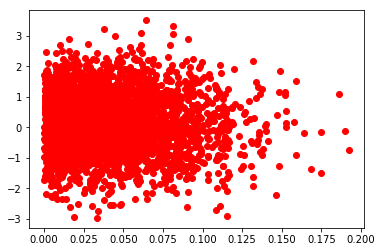

IS_BETA OOS_BETA


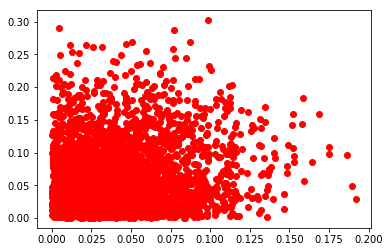

IS_BETA OOS_ANNUALIZED RETURN


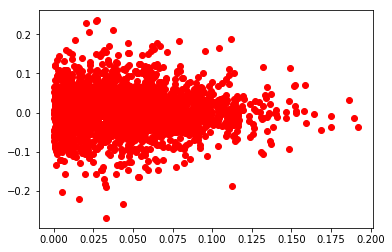

IS_BETA OOS_FACTOR SHARPE


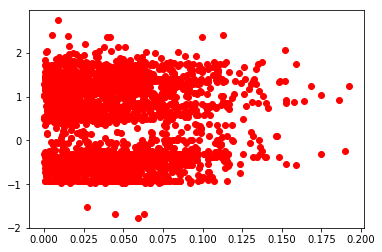

IS_EXTREME STABILITY OOS_PROFITABILITY


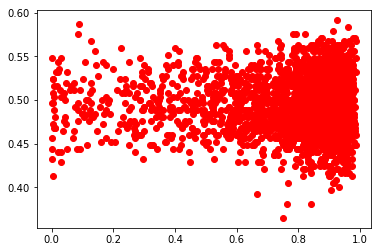

IS_EXTREME STABILITY OOS_SHARPE DIFFERENCE SLIPPAGE


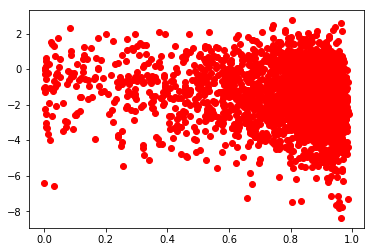

IS_EXTREME STABILITY OOS_SHARPE


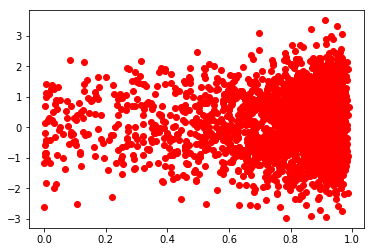

IS_EXTREME STABILITY OOS_BETA


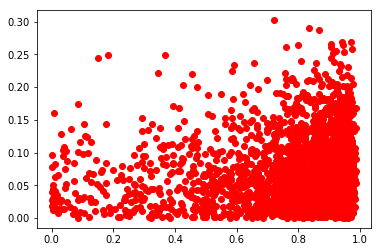

IS_EXTREME STABILITY OOS_ANNUALIZED RETURN


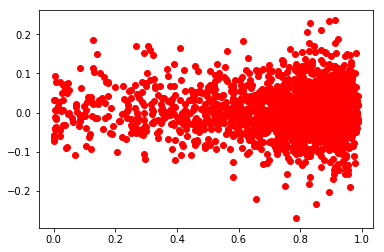

IS_EXTREME STABILITY OOS_FACTOR SHARPE


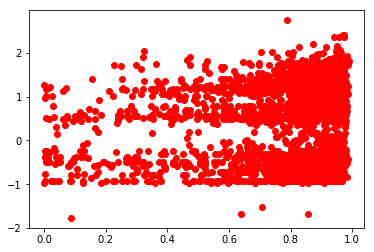

IS_EXTREME STABILITY ROLLING 600 OOS_PROFITABILITY


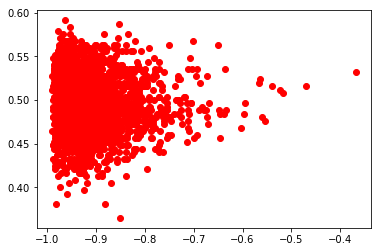

IS_EXTREME STABILITY ROLLING 600 OOS_SHARPE DIFFERENCE SLIPPAGE


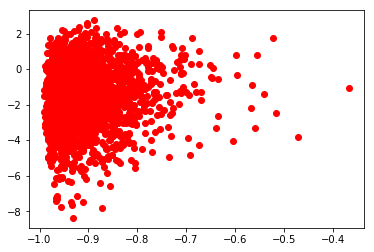

IS_EXTREME STABILITY ROLLING 600 OOS_SHARPE


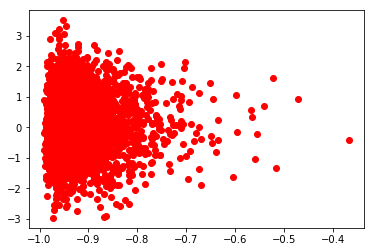

IS_EXTREME STABILITY ROLLING 600 OOS_BETA


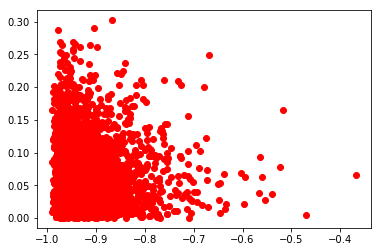

IS_EXTREME STABILITY ROLLING 600 OOS_ANNUALIZED RETURN


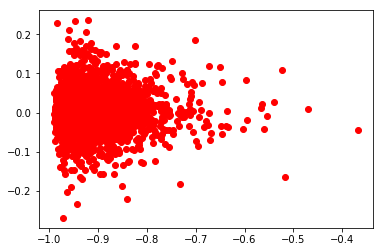

IS_EXTREME STABILITY ROLLING 600 OOS_FACTOR SHARPE


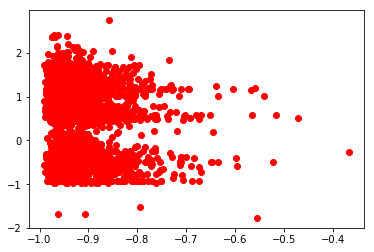

IS_FACTOR PROFITABILITY OOS_PROFITABILITY


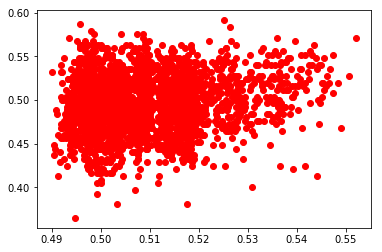

IS_FACTOR PROFITABILITY OOS_SHARPE DIFFERENCE SLIPPAGE


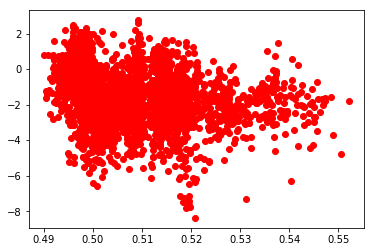

IS_FACTOR PROFITABILITY OOS_SHARPE


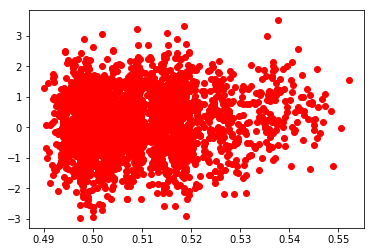

IS_FACTOR PROFITABILITY OOS_BETA


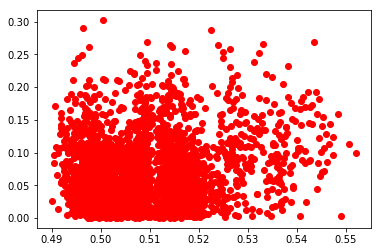

IS_FACTOR PROFITABILITY OOS_ANNUALIZED RETURN


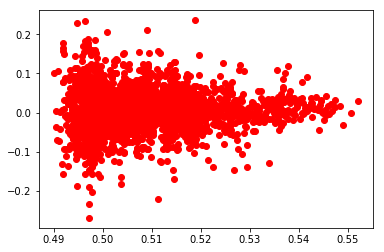

IS_FACTOR PROFITABILITY OOS_FACTOR SHARPE


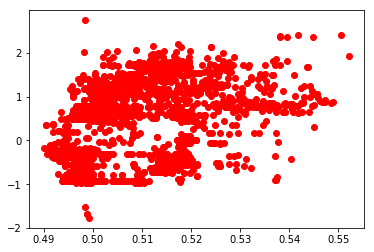

IS_FACTOR SHARPE OOS_PROFITABILITY


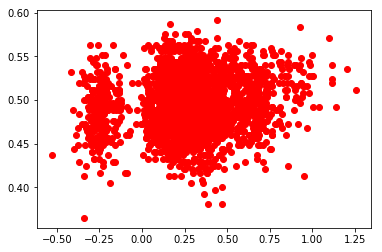

IS_FACTOR SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


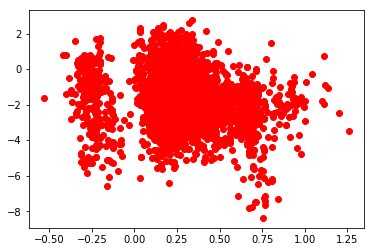

IS_FACTOR SHARPE OOS_SHARPE


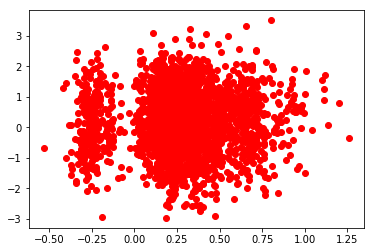

IS_FACTOR SHARPE OOS_BETA


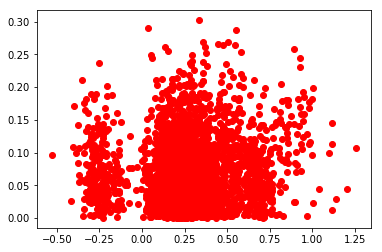

IS_FACTOR SHARPE OOS_ANNUALIZED RETURN


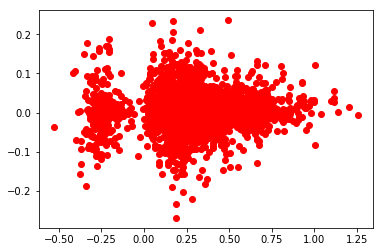

IS_FACTOR SHARPE OOS_FACTOR SHARPE


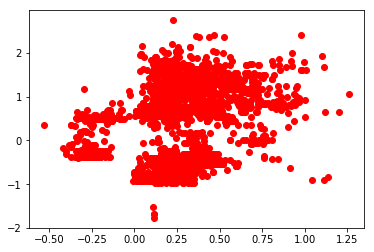

IS_MIN FACTOR PROFITABILITY 45 OOS_PROFITABILITY


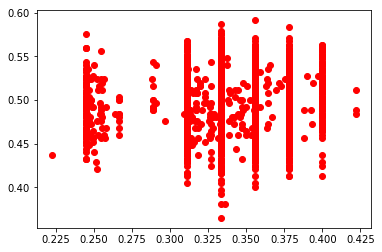

IS_MIN FACTOR PROFITABILITY 45 OOS_SHARPE DIFFERENCE SLIPPAGE


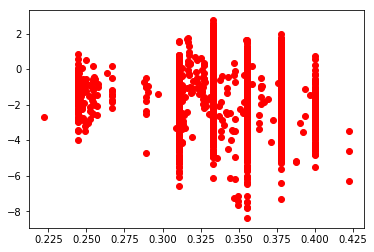

IS_MIN FACTOR PROFITABILITY 45 OOS_SHARPE


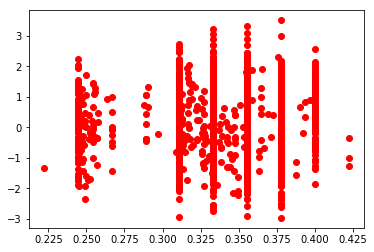

IS_MIN FACTOR PROFITABILITY 45 OOS_BETA


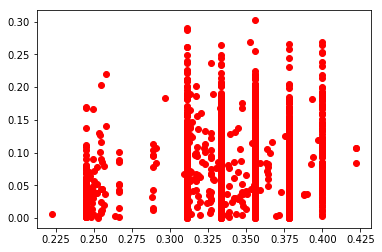

IS_MIN FACTOR PROFITABILITY 45 OOS_ANNUALIZED RETURN


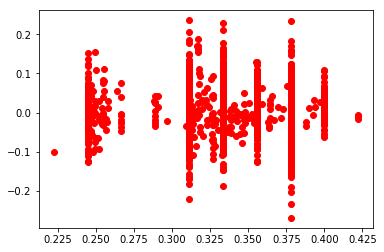

IS_MIN FACTOR PROFITABILITY 45 OOS_FACTOR SHARPE


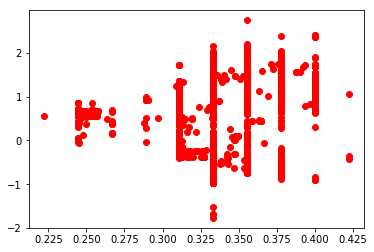

IS_MIN FACTOR PROFITABILITY 90 OOS_PROFITABILITY


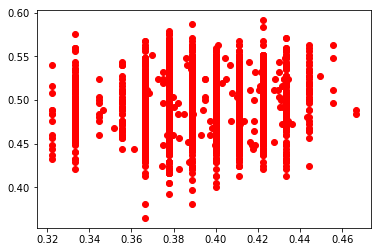

IS_MIN FACTOR PROFITABILITY 90 OOS_SHARPE DIFFERENCE SLIPPAGE


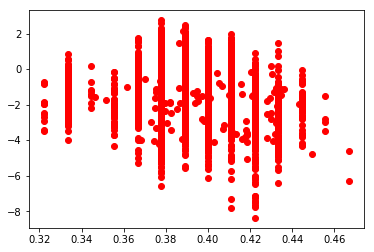

IS_MIN FACTOR PROFITABILITY 90 OOS_SHARPE


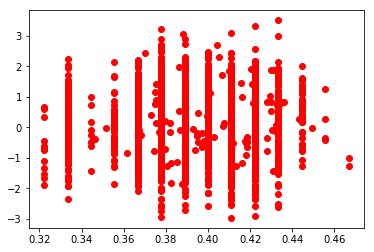

IS_MIN FACTOR PROFITABILITY 90 OOS_BETA


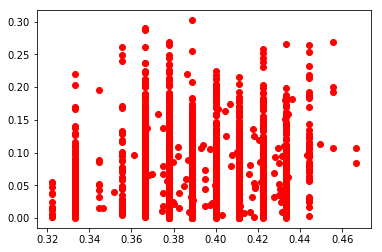

IS_MIN FACTOR PROFITABILITY 90 OOS_ANNUALIZED RETURN


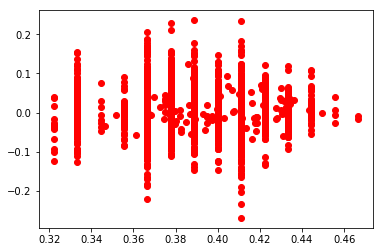

IS_MIN FACTOR PROFITABILITY 90 OOS_FACTOR SHARPE


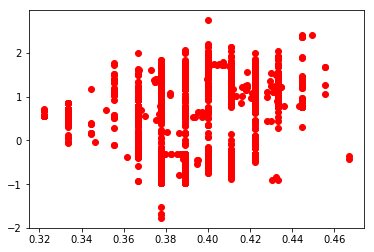

IS_MIN PROFITABILITY 45 OOS_PROFITABILITY


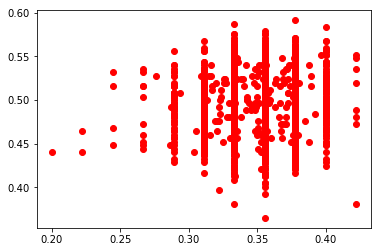

IS_MIN PROFITABILITY 45 OOS_SHARPE DIFFERENCE SLIPPAGE


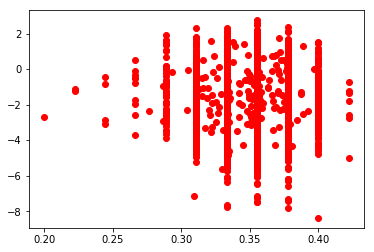

IS_MIN PROFITABILITY 45 OOS_SHARPE


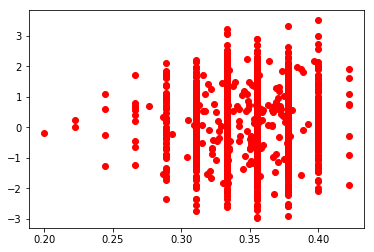

IS_MIN PROFITABILITY 45 OOS_BETA


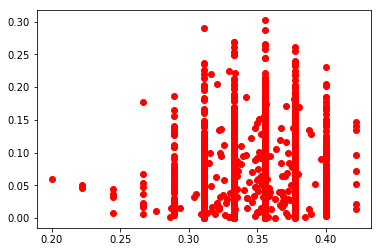

IS_MIN PROFITABILITY 45 OOS_ANNUALIZED RETURN


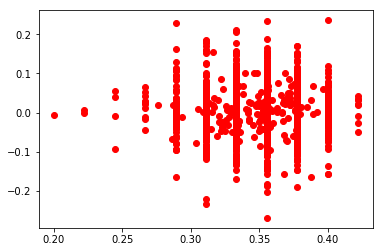

IS_MIN PROFITABILITY 45 OOS_FACTOR SHARPE


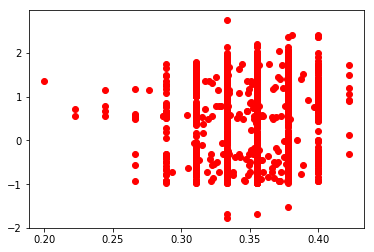

IS_MIN PROFITABILITY 90 OOS_PROFITABILITY


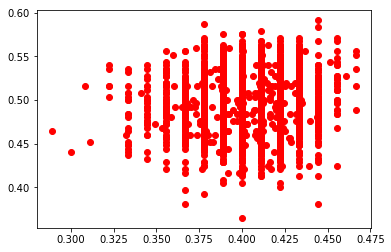

IS_MIN PROFITABILITY 90 OOS_SHARPE DIFFERENCE SLIPPAGE


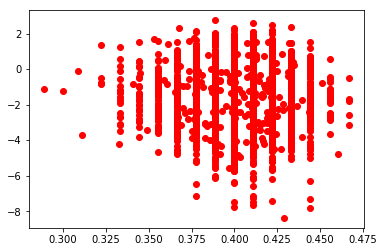

IS_MIN PROFITABILITY 90 OOS_SHARPE


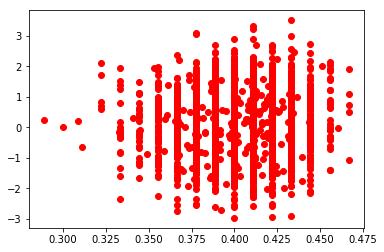

IS_MIN PROFITABILITY 90 OOS_BETA


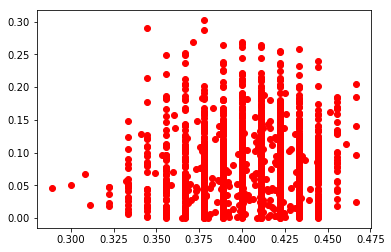

IS_MIN PROFITABILITY 90 OOS_ANNUALIZED RETURN


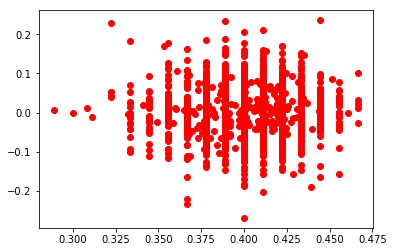

IS_MIN PROFITABILITY 90 OOS_FACTOR SHARPE


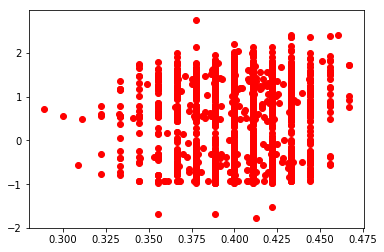

IS_MIN PROFITABILITY DIFFERENCE 45 OOS_PROFITABILITY


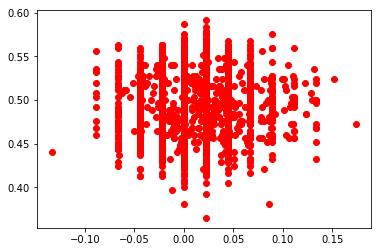

IS_MIN PROFITABILITY DIFFERENCE 45 OOS_SHARPE DIFFERENCE SLIPPAGE


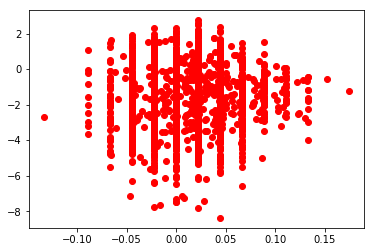

IS_MIN PROFITABILITY DIFFERENCE 45 OOS_SHARPE


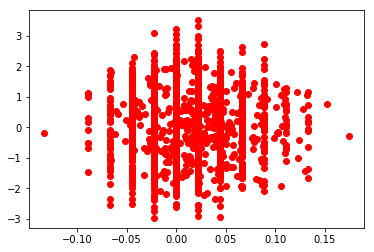

IS_MIN PROFITABILITY DIFFERENCE 45 OOS_BETA


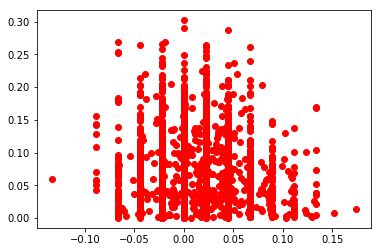

IS_MIN PROFITABILITY DIFFERENCE 45 OOS_ANNUALIZED RETURN


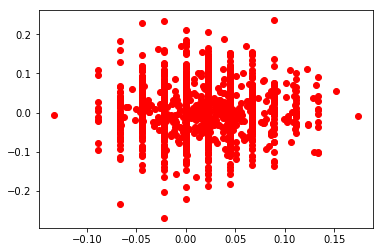

IS_MIN PROFITABILITY DIFFERENCE 45 OOS_FACTOR SHARPE


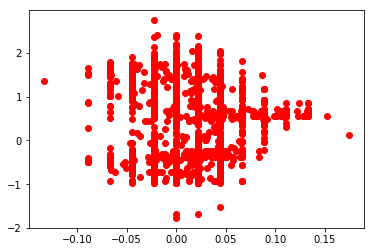

IS_MIN PROFITABILITY DIFFERENCE 90 OOS_PROFITABILITY


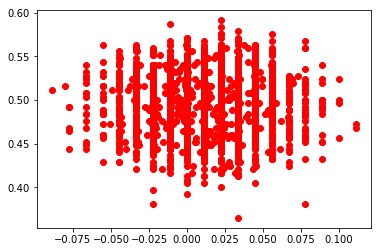

IS_MIN PROFITABILITY DIFFERENCE 90 OOS_SHARPE DIFFERENCE SLIPPAGE


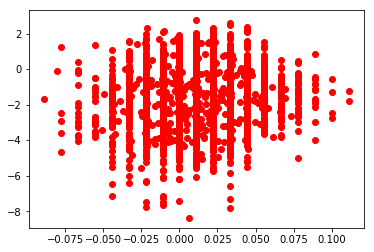

IS_MIN PROFITABILITY DIFFERENCE 90 OOS_SHARPE


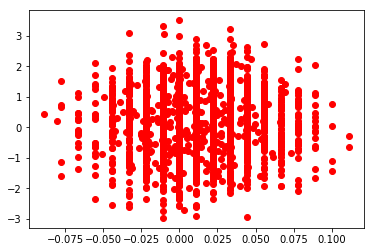

IS_MIN PROFITABILITY DIFFERENCE 90 OOS_BETA


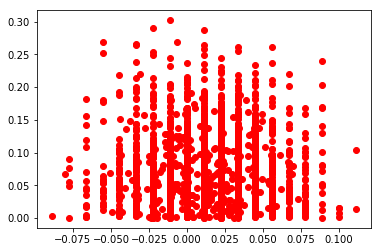

IS_MIN PROFITABILITY DIFFERENCE 90 OOS_ANNUALIZED RETURN


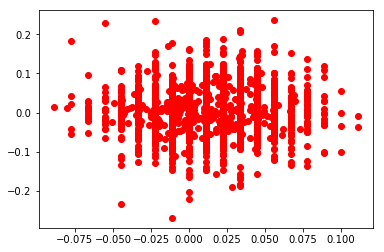

IS_MIN PROFITABILITY DIFFERENCE 90 OOS_FACTOR SHARPE


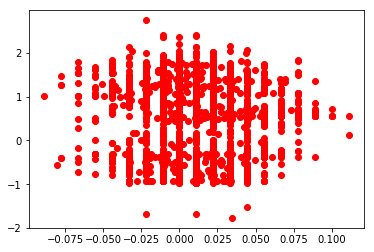

IS_MIN ROLLING SHARPE OOS_PROFITABILITY


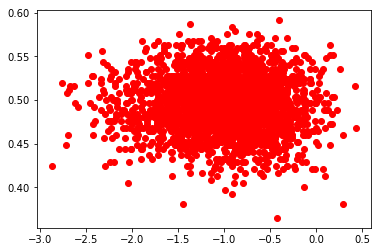

IS_MIN ROLLING SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


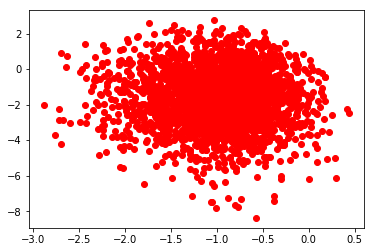

IS_MIN ROLLING SHARPE OOS_SHARPE


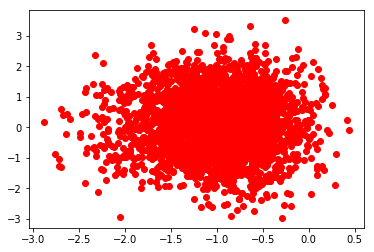

IS_MIN ROLLING SHARPE OOS_BETA


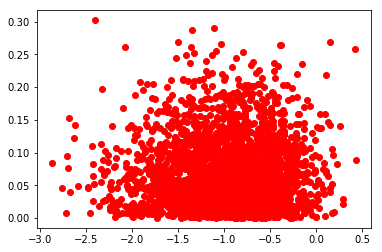

IS_MIN ROLLING SHARPE OOS_ANNUALIZED RETURN


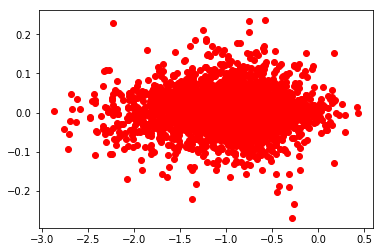

IS_MIN ROLLING SHARPE OOS_FACTOR SHARPE


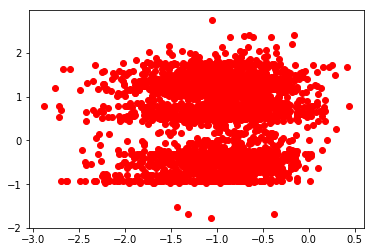

IS_MIN ROLLING SHARPE 45 OOS_PROFITABILITY


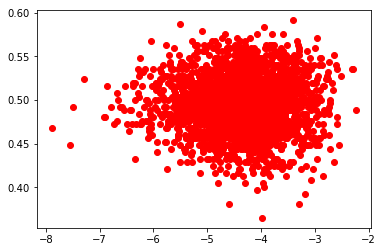

IS_MIN ROLLING SHARPE 45 OOS_SHARPE DIFFERENCE SLIPPAGE


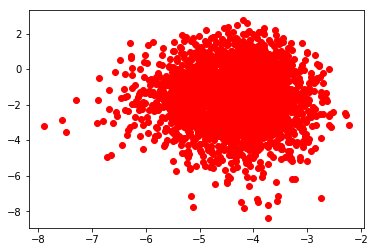

IS_MIN ROLLING SHARPE 45 OOS_SHARPE


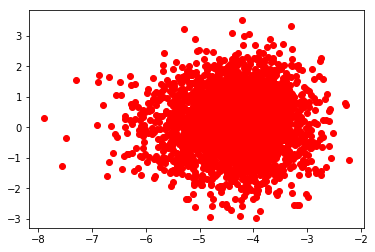

IS_MIN ROLLING SHARPE 45 OOS_BETA


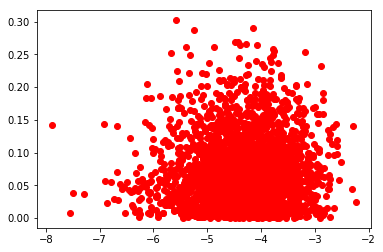

IS_MIN ROLLING SHARPE 45 OOS_ANNUALIZED RETURN


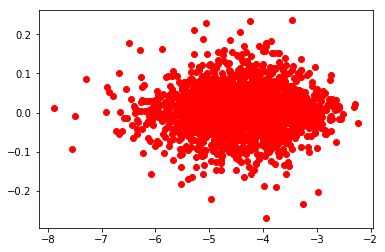

IS_MIN ROLLING SHARPE 45 OOS_FACTOR SHARPE


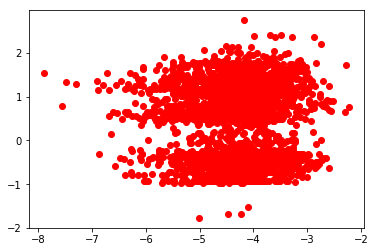

IS_MIN ROLLING SHARPE 90 OOS_PROFITABILITY


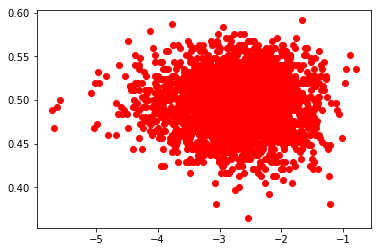

IS_MIN ROLLING SHARPE 90 OOS_SHARPE DIFFERENCE SLIPPAGE


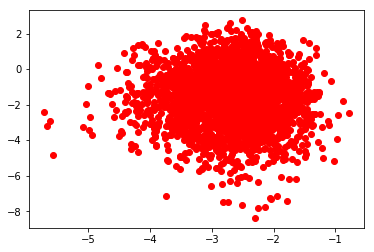

IS_MIN ROLLING SHARPE 90 OOS_SHARPE


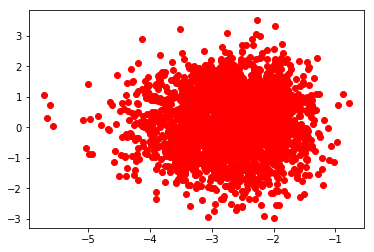

IS_MIN ROLLING SHARPE 90 OOS_BETA


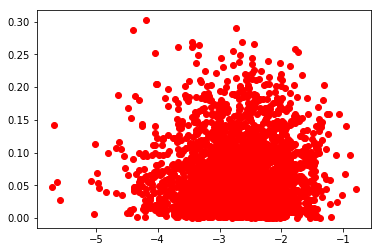

IS_MIN ROLLING SHARPE 90 OOS_ANNUALIZED RETURN


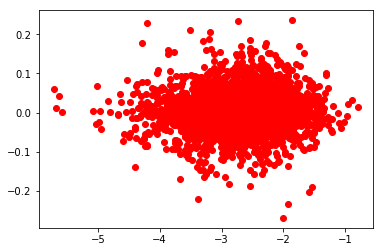

IS_MIN ROLLING SHARPE 90 OOS_FACTOR SHARPE


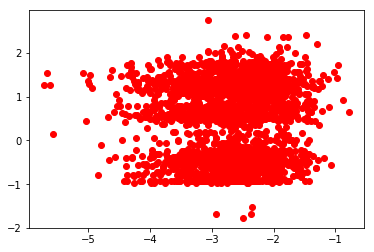

IS_ONE STD SHARPE OOS_PROFITABILITY


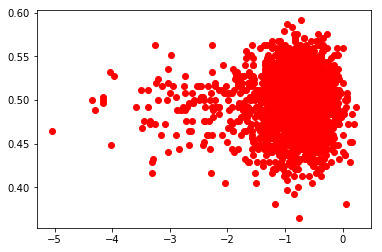

IS_ONE STD SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


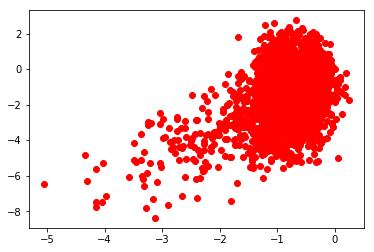

IS_ONE STD SHARPE OOS_SHARPE


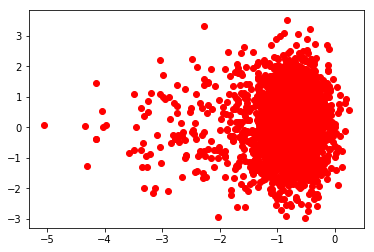

IS_ONE STD SHARPE OOS_BETA


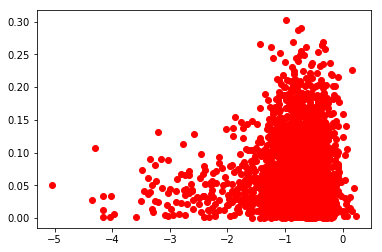

IS_ONE STD SHARPE OOS_ANNUALIZED RETURN


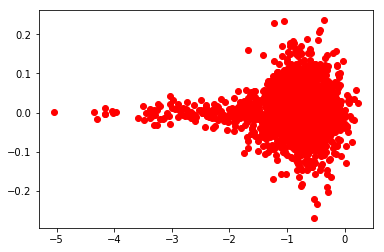

IS_ONE STD SHARPE OOS_FACTOR SHARPE


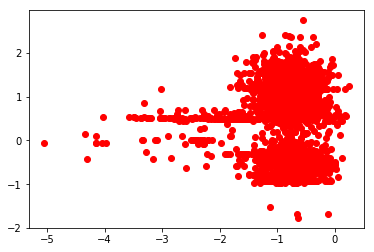

IS_PROFITABILITY OOS_PROFITABILITY


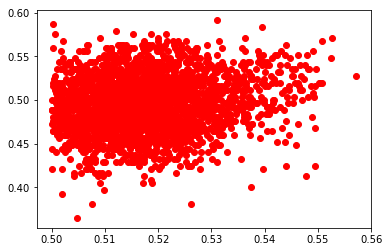

IS_PROFITABILITY OOS_SHARPE DIFFERENCE SLIPPAGE


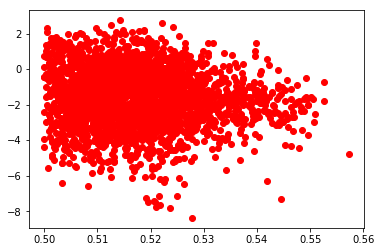

IS_PROFITABILITY OOS_SHARPE


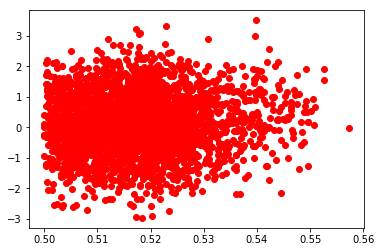

IS_PROFITABILITY OOS_BETA


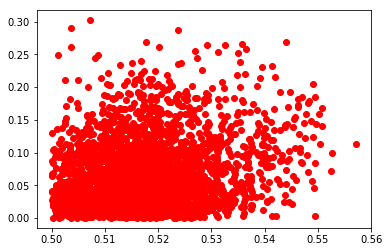

IS_PROFITABILITY OOS_ANNUALIZED RETURN


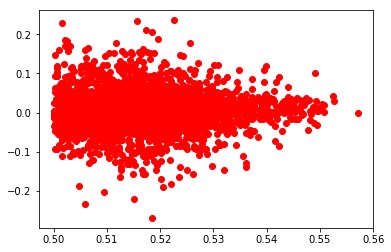

IS_PROFITABILITY OOS_FACTOR SHARPE


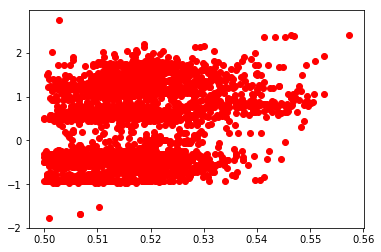

IS_PROFITABILITY DIFFERENCE OOS_PROFITABILITY


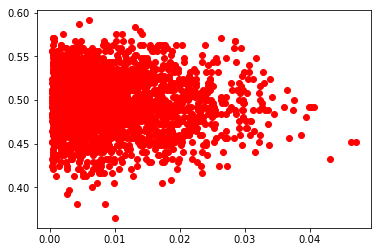

IS_PROFITABILITY DIFFERENCE OOS_SHARPE DIFFERENCE SLIPPAGE


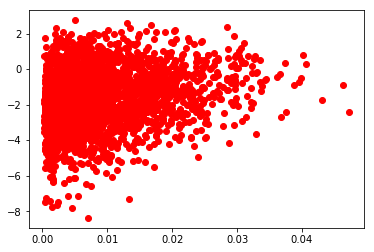

IS_PROFITABILITY DIFFERENCE OOS_SHARPE


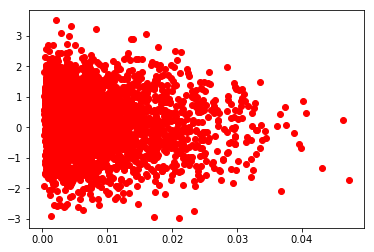

IS_PROFITABILITY DIFFERENCE OOS_BETA


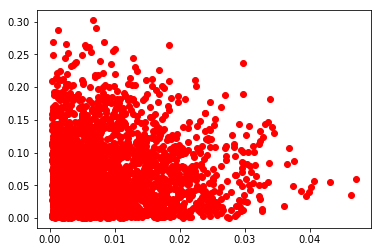

IS_PROFITABILITY DIFFERENCE OOS_ANNUALIZED RETURN


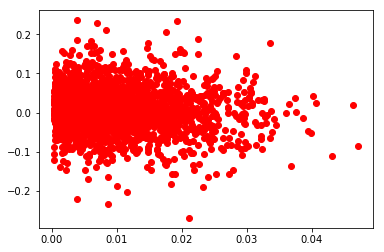

IS_PROFITABILITY DIFFERENCE OOS_FACTOR SHARPE


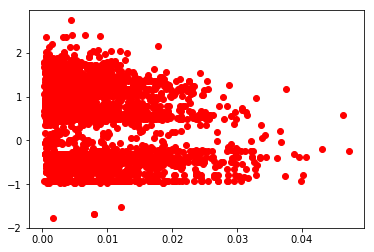

IS_PROFITABILITY DROP 45 OOS_PROFITABILITY


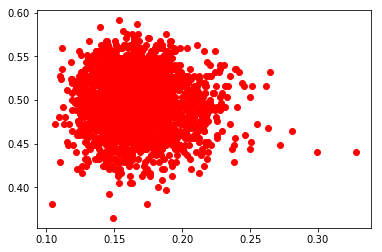

IS_PROFITABILITY DROP 45 OOS_SHARPE DIFFERENCE SLIPPAGE


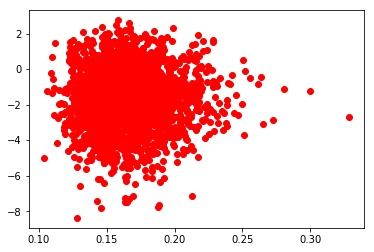

IS_PROFITABILITY DROP 45 OOS_SHARPE


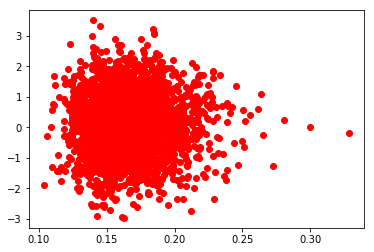

IS_PROFITABILITY DROP 45 OOS_BETA


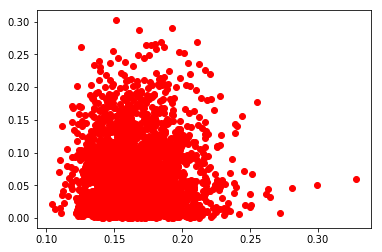

IS_PROFITABILITY DROP 45 OOS_ANNUALIZED RETURN


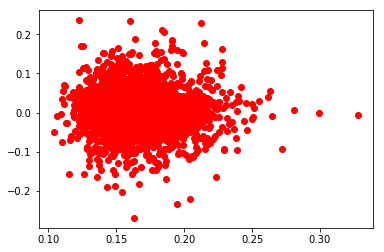

IS_PROFITABILITY DROP 45 OOS_FACTOR SHARPE


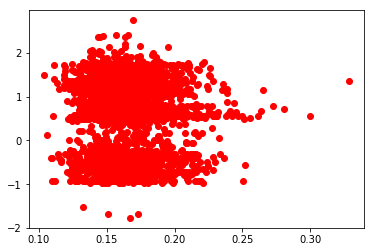

IS_PROFITABILITY DROP 90 OOS_PROFITABILITY


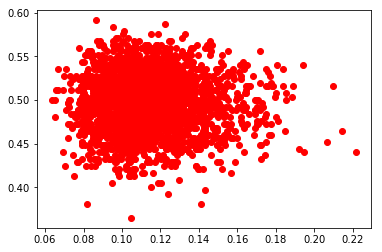

IS_PROFITABILITY DROP 90 OOS_SHARPE DIFFERENCE SLIPPAGE


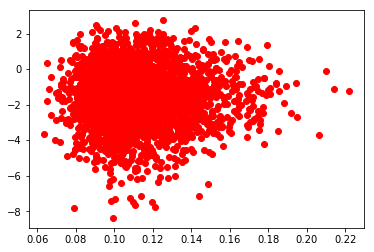

IS_PROFITABILITY DROP 90 OOS_SHARPE


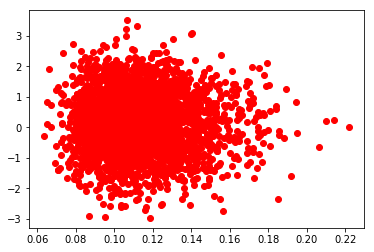

IS_PROFITABILITY DROP 90 OOS_BETA


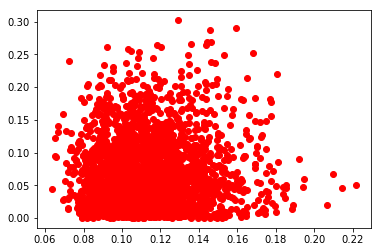

IS_PROFITABILITY DROP 90 OOS_ANNUALIZED RETURN


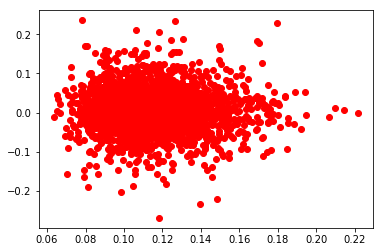

IS_PROFITABILITY DROP 90 OOS_FACTOR SHARPE


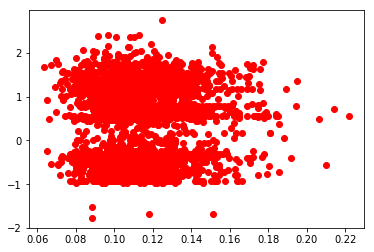

IS_PROFITABILITY SLIPPAGE OOS_PROFITABILITY


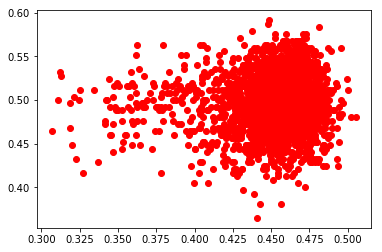

IS_PROFITABILITY SLIPPAGE OOS_SHARPE DIFFERENCE SLIPPAGE


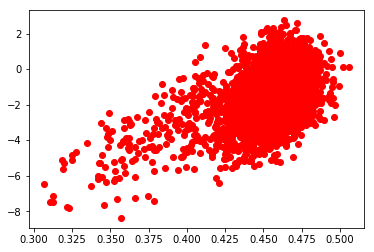

IS_PROFITABILITY SLIPPAGE OOS_SHARPE


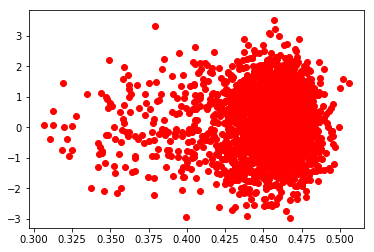

IS_PROFITABILITY SLIPPAGE OOS_BETA


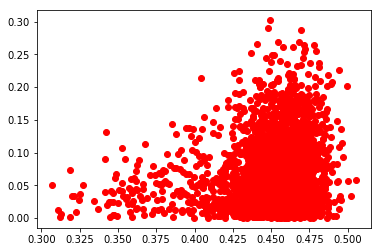

IS_PROFITABILITY SLIPPAGE OOS_ANNUALIZED RETURN


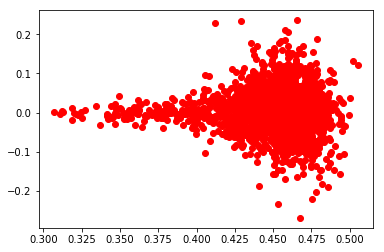

IS_PROFITABILITY SLIPPAGE OOS_FACTOR SHARPE


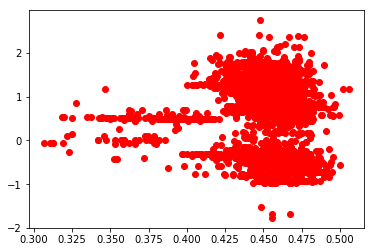

IS_RAW BETA OOS_PROFITABILITY


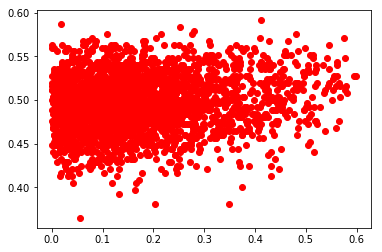

IS_RAW BETA OOS_SHARPE DIFFERENCE SLIPPAGE


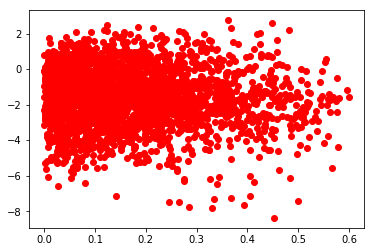

IS_RAW BETA OOS_SHARPE


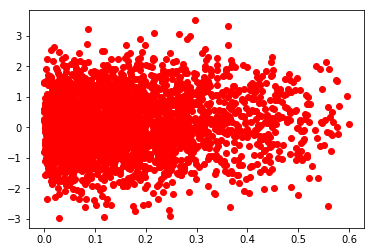

IS_RAW BETA OOS_BETA


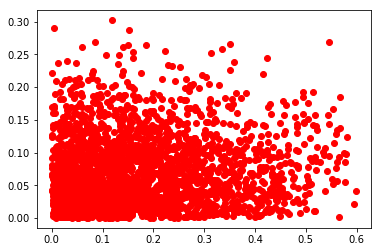

IS_RAW BETA OOS_ANNUALIZED RETURN


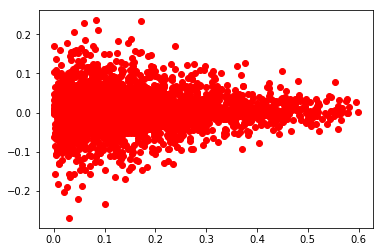

IS_RAW BETA OOS_FACTOR SHARPE


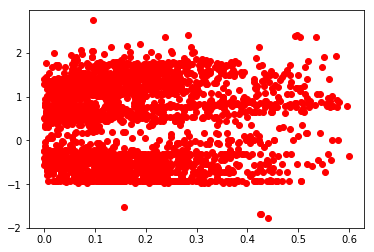

IS_RELATIVE SHARPE OOS_PROFITABILITY


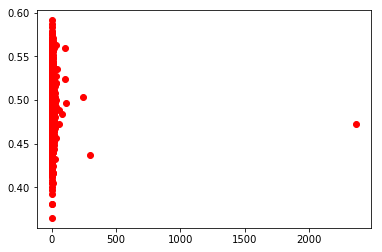

IS_RELATIVE SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


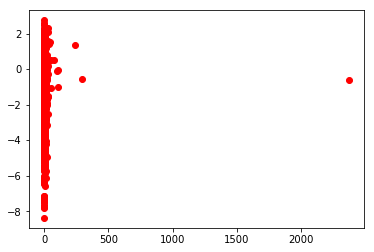

IS_RELATIVE SHARPE OOS_SHARPE


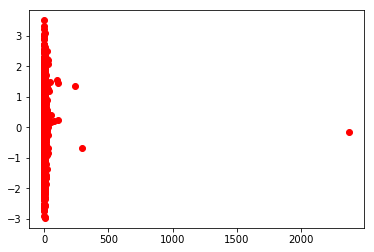

IS_RELATIVE SHARPE OOS_BETA


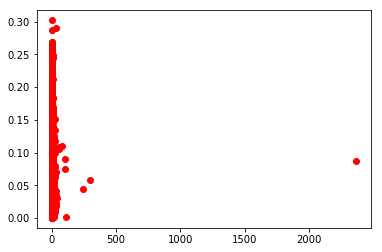

IS_RELATIVE SHARPE OOS_ANNUALIZED RETURN


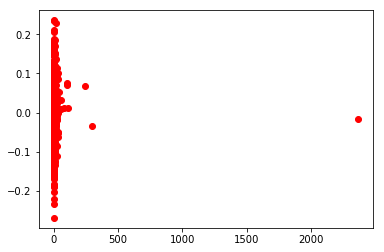

IS_RELATIVE SHARPE OOS_FACTOR SHARPE


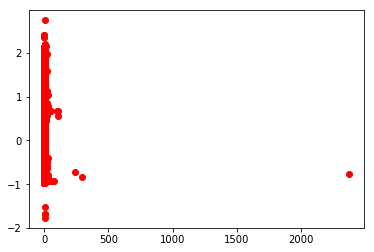

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_PROFITABILITY


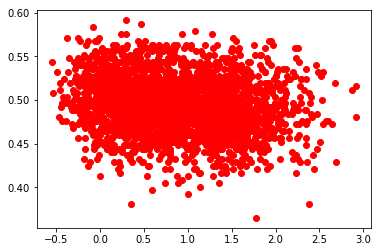

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_SHARPE DIFFERENCE SLIPPAGE


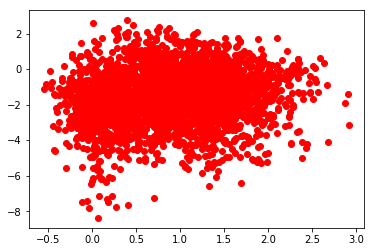

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_SHARPE


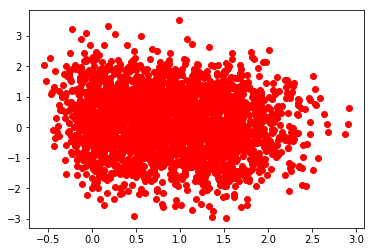

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_BETA


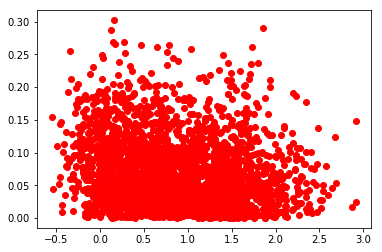

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_ANNUALIZED RETURN


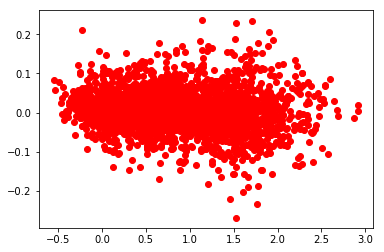

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_FACTOR SHARPE


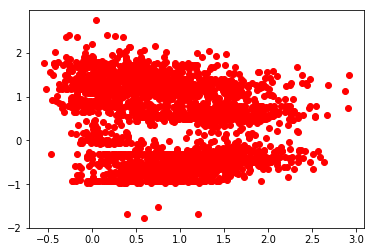

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_PROFITABILITY


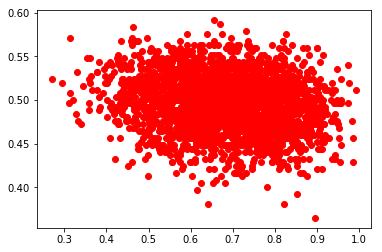

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_SHARPE DIFFERENCE SLIPPAGE


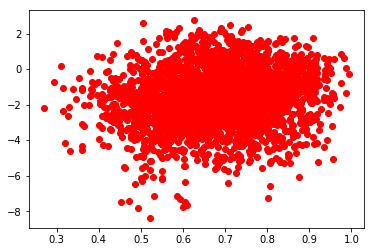

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_SHARPE


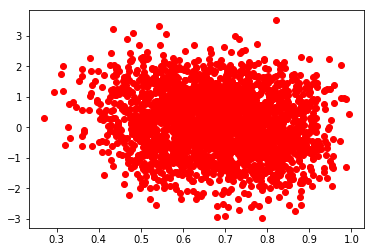

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_BETA


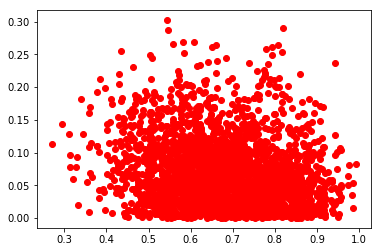

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_ANNUALIZED RETURN


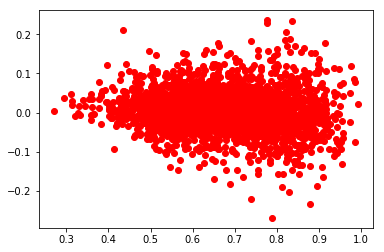

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_FACTOR SHARPE


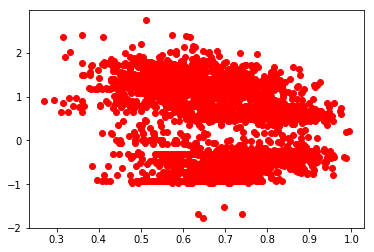

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_PROFITABILITY


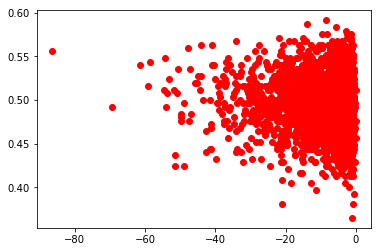

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_SHARPE DIFFERENCE SLIPPAGE


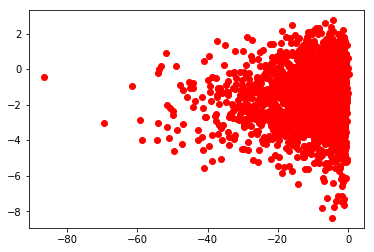

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_SHARPE


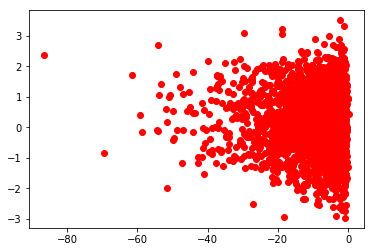

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_BETA


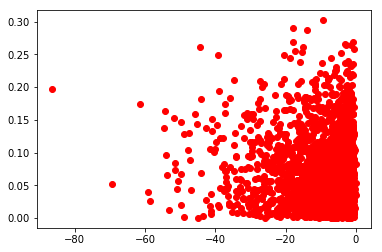

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_ANNUALIZED RETURN


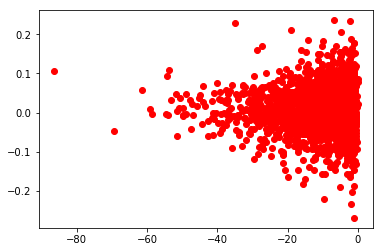

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_FACTOR SHARPE


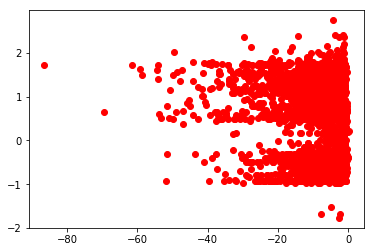

IS_RELATIVE SHARPE SLIPPAGE OOS_PROFITABILITY


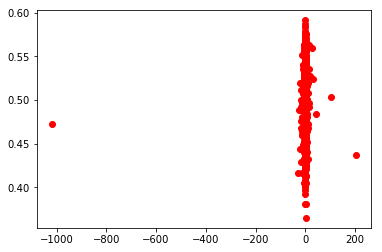

IS_RELATIVE SHARPE SLIPPAGE OOS_SHARPE DIFFERENCE SLIPPAGE


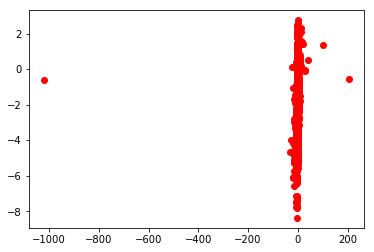

IS_RELATIVE SHARPE SLIPPAGE OOS_SHARPE


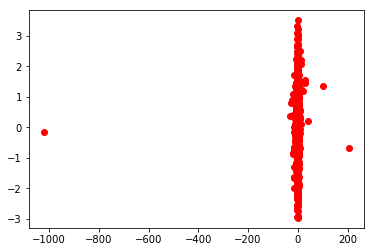

IS_RELATIVE SHARPE SLIPPAGE OOS_BETA


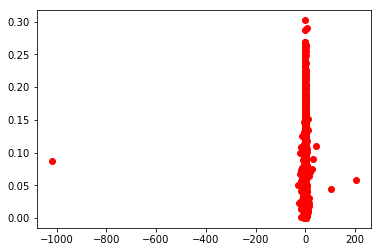

IS_RELATIVE SHARPE SLIPPAGE OOS_ANNUALIZED RETURN


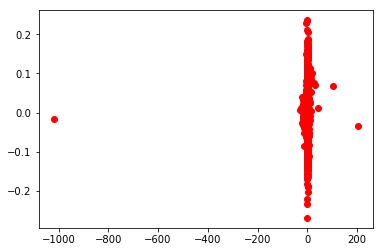

IS_RELATIVE SHARPE SLIPPAGE OOS_FACTOR SHARPE


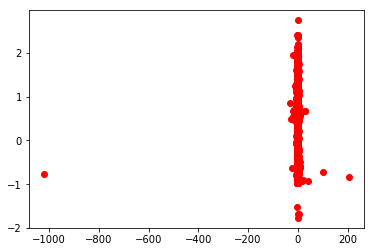

IS_ROLLING SHARPE BETA OOS_PROFITABILITY


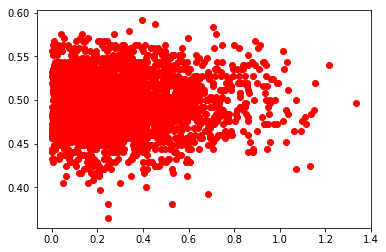

IS_ROLLING SHARPE BETA OOS_SHARPE DIFFERENCE SLIPPAGE


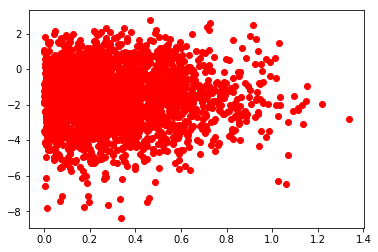

IS_ROLLING SHARPE BETA OOS_SHARPE


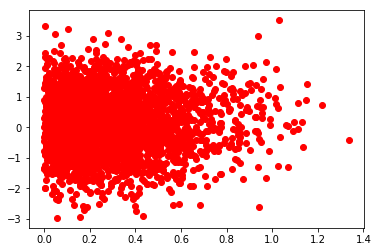

IS_ROLLING SHARPE BETA OOS_BETA


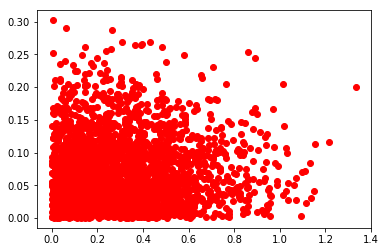

IS_ROLLING SHARPE BETA OOS_ANNUALIZED RETURN


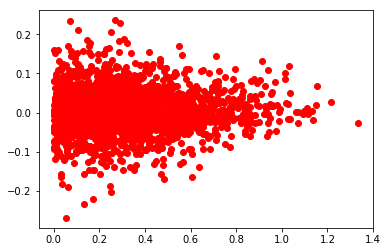

IS_ROLLING SHARPE BETA OOS_FACTOR SHARPE


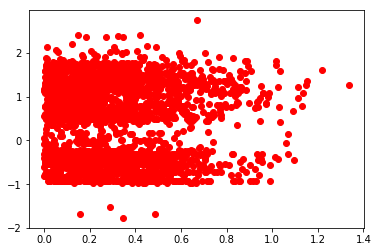

IS_ROLLING SHARPE ERROR OOS_PROFITABILITY


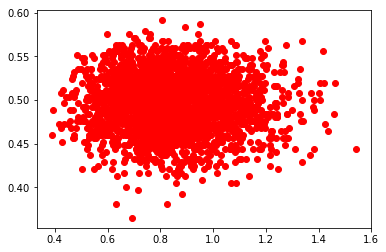

IS_ROLLING SHARPE ERROR OOS_SHARPE DIFFERENCE SLIPPAGE


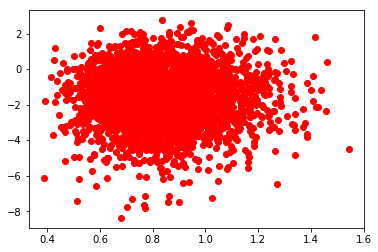

IS_ROLLING SHARPE ERROR OOS_SHARPE


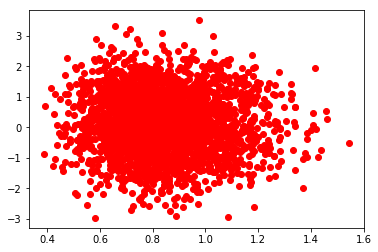

IS_ROLLING SHARPE ERROR OOS_BETA


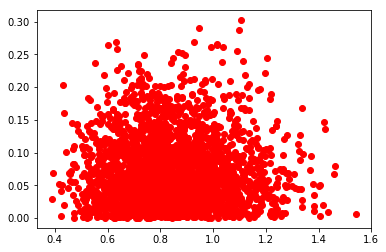

IS_ROLLING SHARPE ERROR OOS_ANNUALIZED RETURN


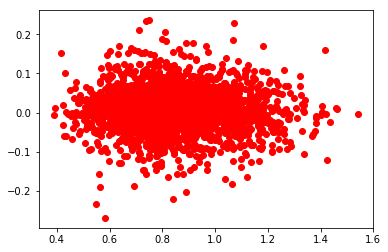

IS_ROLLING SHARPE ERROR OOS_FACTOR SHARPE


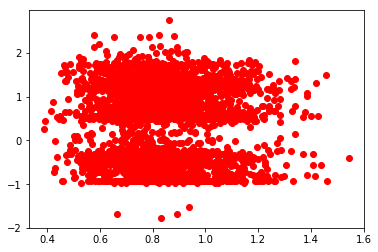

IS_ROLLING SHARPE ERROR 45 OOS_PROFITABILITY


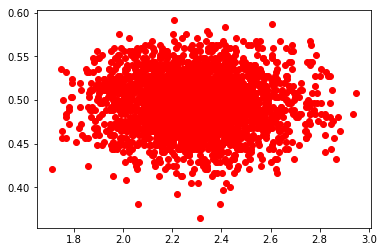

IS_ROLLING SHARPE ERROR 45 OOS_SHARPE DIFFERENCE SLIPPAGE


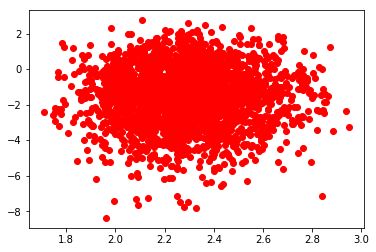

IS_ROLLING SHARPE ERROR 45 OOS_SHARPE


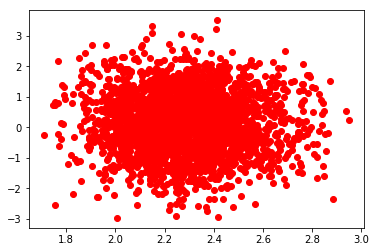

IS_ROLLING SHARPE ERROR 45 OOS_BETA


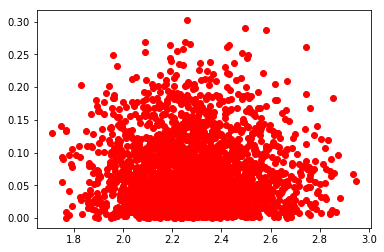

IS_ROLLING SHARPE ERROR 45 OOS_ANNUALIZED RETURN


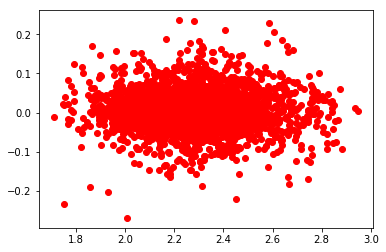

IS_ROLLING SHARPE ERROR 45 OOS_FACTOR SHARPE


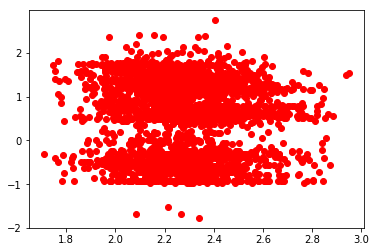

IS_ROLLING SHARPE ERROR 90 OOS_PROFITABILITY


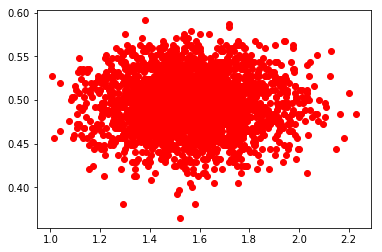

IS_ROLLING SHARPE ERROR 90 OOS_SHARPE DIFFERENCE SLIPPAGE


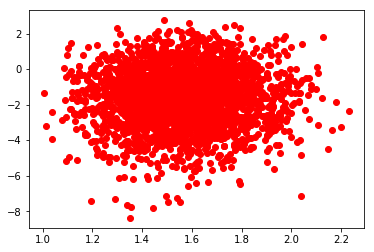

IS_ROLLING SHARPE ERROR 90 OOS_SHARPE


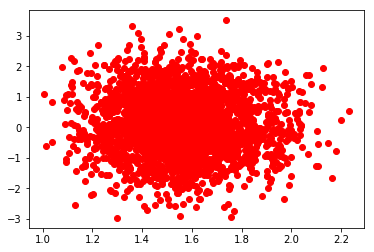

IS_ROLLING SHARPE ERROR 90 OOS_BETA


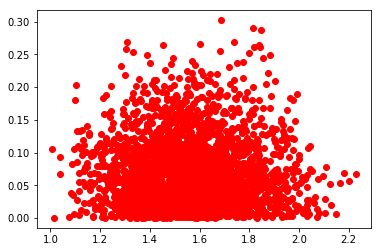

IS_ROLLING SHARPE ERROR 90 OOS_ANNUALIZED RETURN


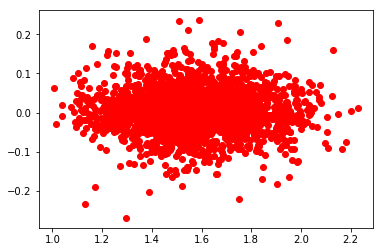

IS_ROLLING SHARPE ERROR 90 OOS_FACTOR SHARPE


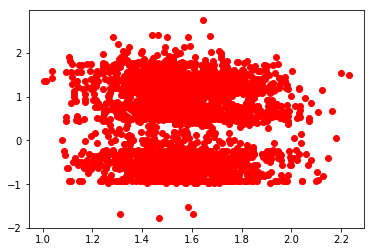

IS_ROLLING SHARPE STABILITY OOS_PROFITABILITY


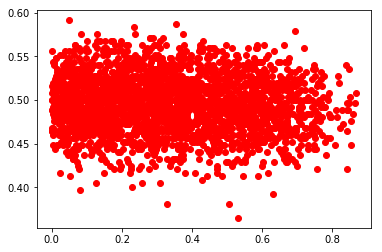

IS_ROLLING SHARPE STABILITY OOS_SHARPE DIFFERENCE SLIPPAGE


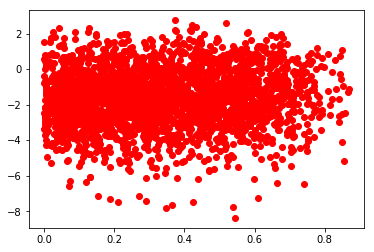

IS_ROLLING SHARPE STABILITY OOS_SHARPE


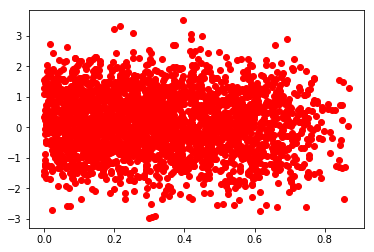

IS_ROLLING SHARPE STABILITY OOS_BETA


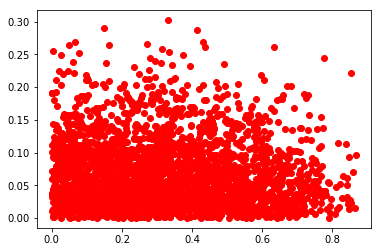

IS_ROLLING SHARPE STABILITY OOS_ANNUALIZED RETURN


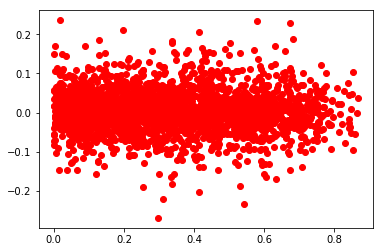

IS_ROLLING SHARPE STABILITY OOS_FACTOR SHARPE


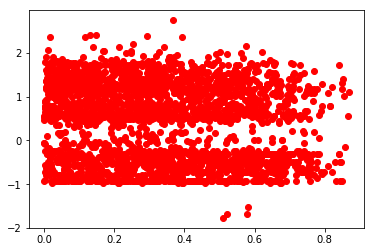

IS_SHARPE OOS_PROFITABILITY


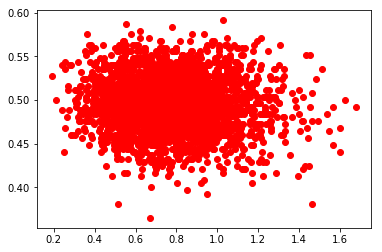

IS_SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


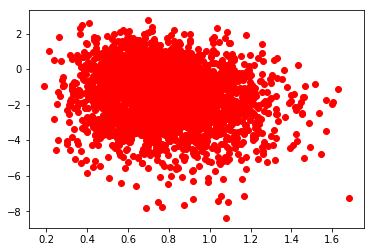

IS_SHARPE OOS_SHARPE


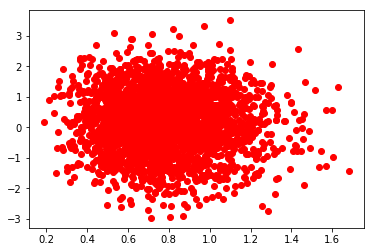

IS_SHARPE OOS_BETA


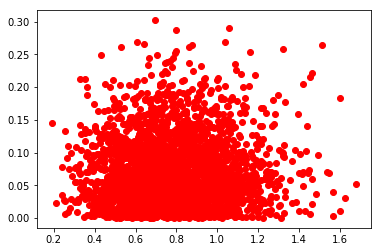

IS_SHARPE OOS_ANNUALIZED RETURN


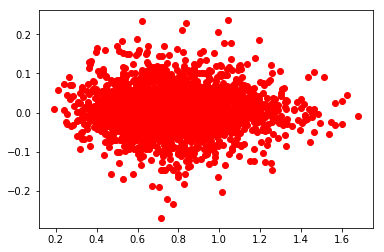

IS_SHARPE OOS_FACTOR SHARPE


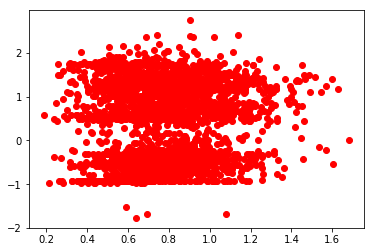

IS_SHARPE DIFFERENCE OOS_PROFITABILITY


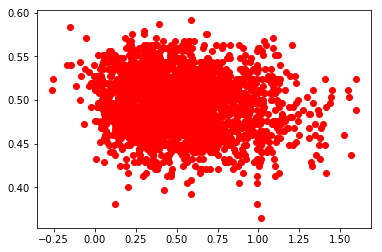

IS_SHARPE DIFFERENCE OOS_SHARPE DIFFERENCE SLIPPAGE


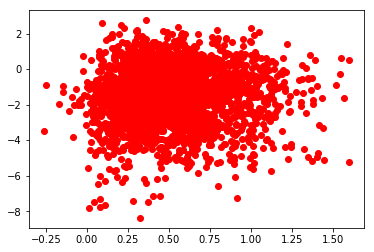

IS_SHARPE DIFFERENCE OOS_SHARPE


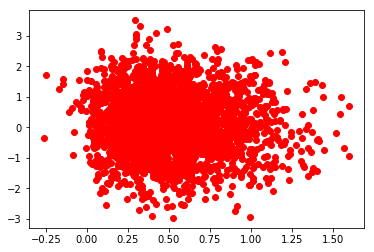

IS_SHARPE DIFFERENCE OOS_BETA


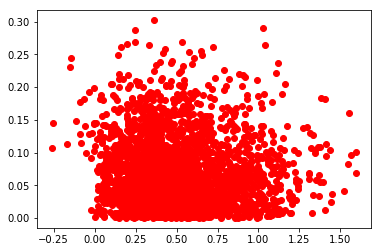

IS_SHARPE DIFFERENCE OOS_ANNUALIZED RETURN


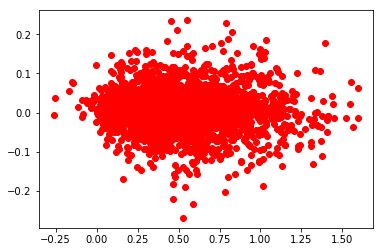

IS_SHARPE DIFFERENCE OOS_FACTOR SHARPE


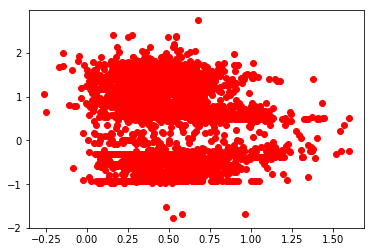

IS_SHARPE DIFFERENCE AVERAGE OOS_PROFITABILITY


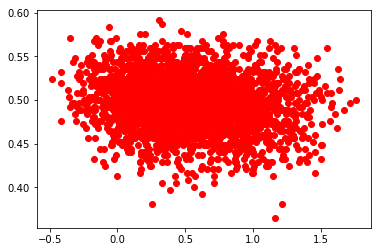

IS_SHARPE DIFFERENCE AVERAGE OOS_SHARPE DIFFERENCE SLIPPAGE


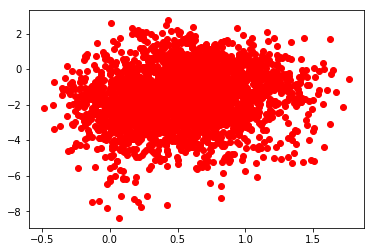

IS_SHARPE DIFFERENCE AVERAGE OOS_SHARPE


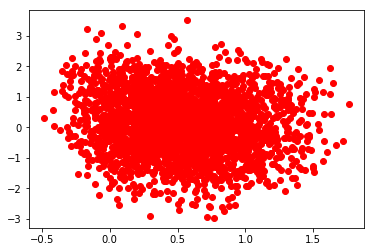

IS_SHARPE DIFFERENCE AVERAGE OOS_BETA


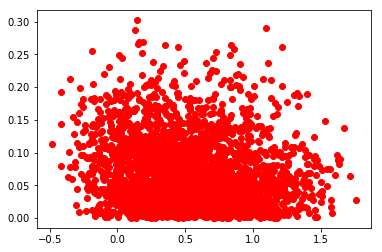

IS_SHARPE DIFFERENCE AVERAGE OOS_ANNUALIZED RETURN


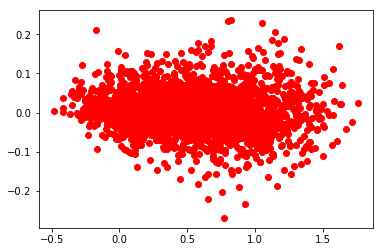

IS_SHARPE DIFFERENCE AVERAGE OOS_FACTOR SHARPE


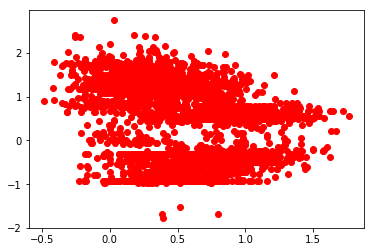

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_PROFITABILITY


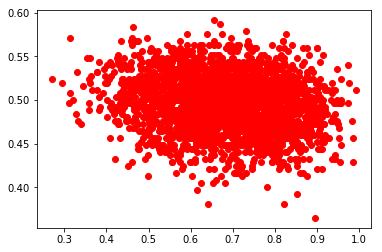

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_SHARPE DIFFERENCE SLIPPAGE


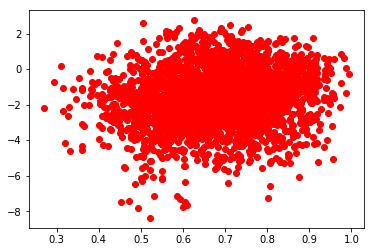

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_SHARPE


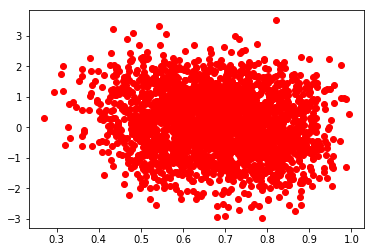

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_BETA


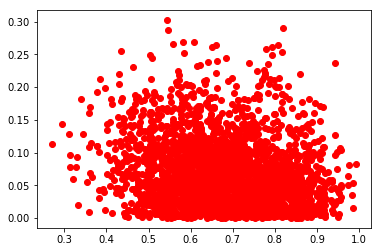

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_ANNUALIZED RETURN


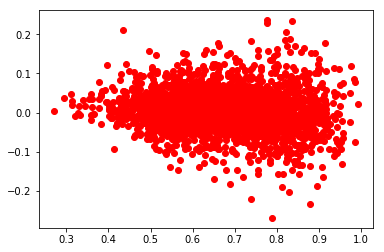

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_FACTOR SHARPE


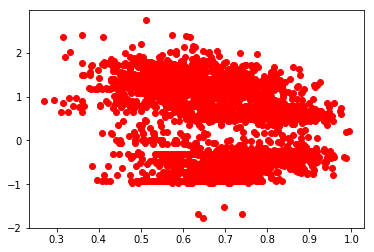

IS_SHARPE DIFFERENCE MIN OOS_PROFITABILITY


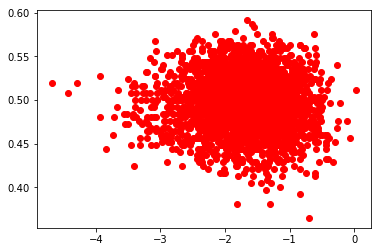

IS_SHARPE DIFFERENCE MIN OOS_SHARPE DIFFERENCE SLIPPAGE


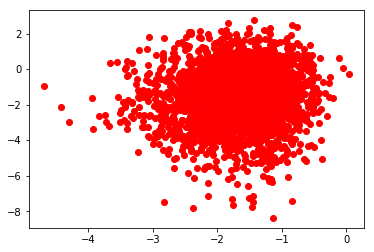

IS_SHARPE DIFFERENCE MIN OOS_SHARPE


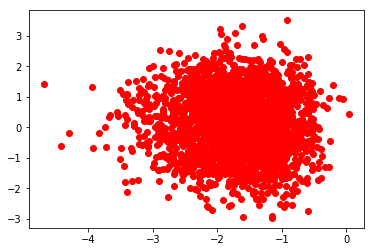

IS_SHARPE DIFFERENCE MIN OOS_BETA


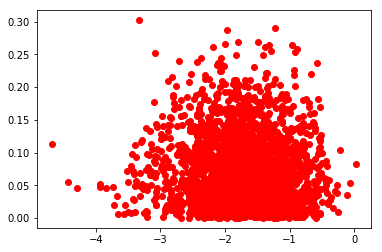

IS_SHARPE DIFFERENCE MIN OOS_ANNUALIZED RETURN


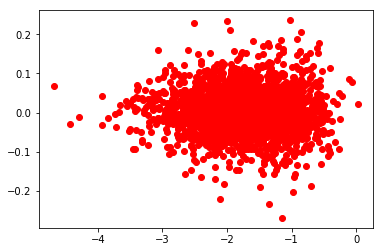

IS_SHARPE DIFFERENCE MIN OOS_FACTOR SHARPE


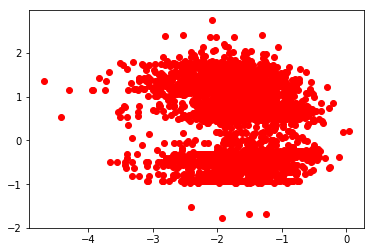

IS_SHARPE DIFFERENCE SLIPPAGE OOS_PROFITABILITY


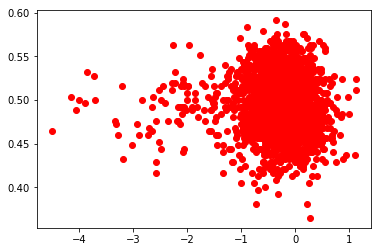

IS_SHARPE DIFFERENCE SLIPPAGE OOS_SHARPE DIFFERENCE SLIPPAGE


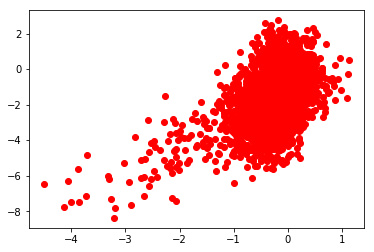

IS_SHARPE DIFFERENCE SLIPPAGE OOS_SHARPE


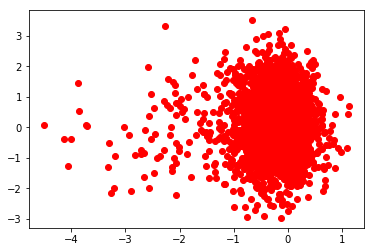

IS_SHARPE DIFFERENCE SLIPPAGE OOS_BETA


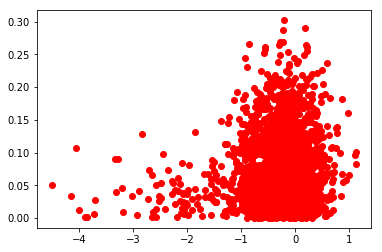

IS_SHARPE DIFFERENCE SLIPPAGE OOS_ANNUALIZED RETURN


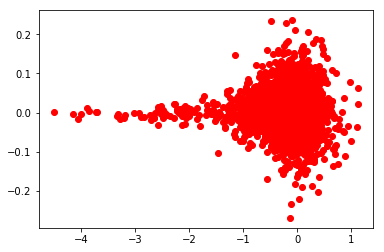

IS_SHARPE DIFFERENCE SLIPPAGE OOS_FACTOR SHARPE


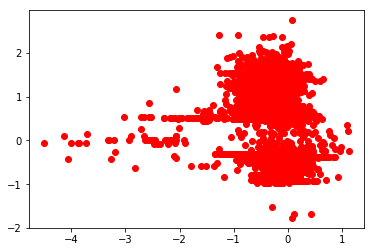

IS_SHARPE SLIPPAGE OOS_PROFITABILITY


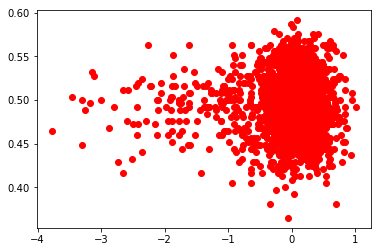

IS_SHARPE SLIPPAGE OOS_SHARPE DIFFERENCE SLIPPAGE


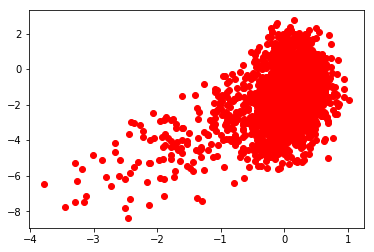

IS_SHARPE SLIPPAGE OOS_SHARPE


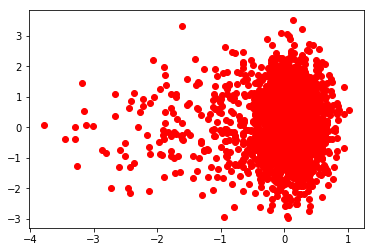

IS_SHARPE SLIPPAGE OOS_BETA


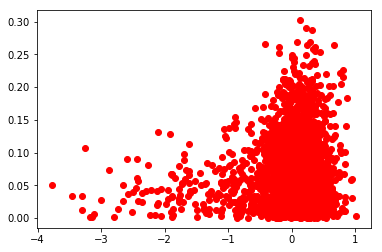

IS_SHARPE SLIPPAGE OOS_ANNUALIZED RETURN


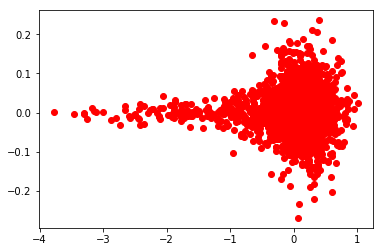

IS_SHARPE SLIPPAGE OOS_FACTOR SHARPE


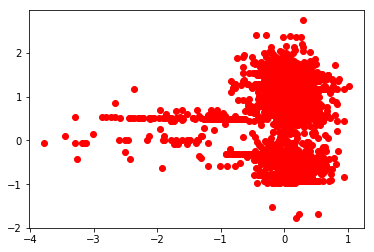

IS_SHARPE SLIPPAGE DECAY OOS_PROFITABILITY


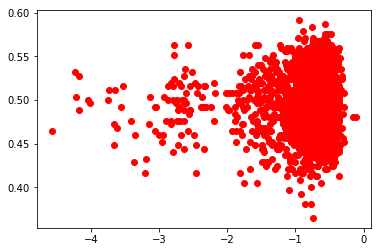

IS_SHARPE SLIPPAGE DECAY OOS_SHARPE DIFFERENCE SLIPPAGE


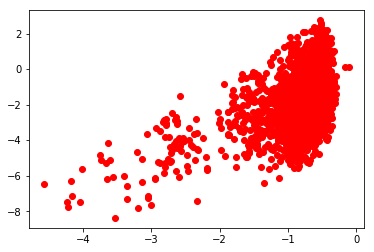

IS_SHARPE SLIPPAGE DECAY OOS_SHARPE


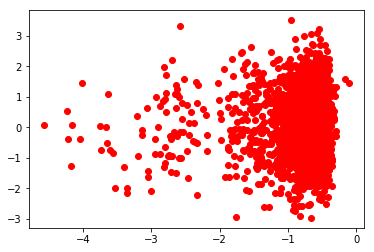

IS_SHARPE SLIPPAGE DECAY OOS_BETA


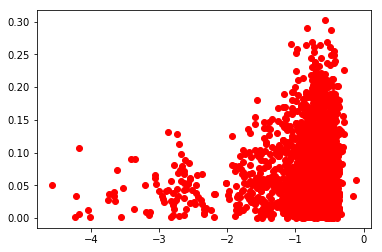

IS_SHARPE SLIPPAGE DECAY OOS_ANNUALIZED RETURN


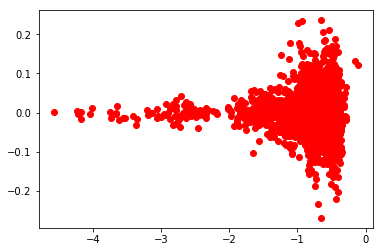

IS_SHARPE SLIPPAGE DECAY OOS_FACTOR SHARPE


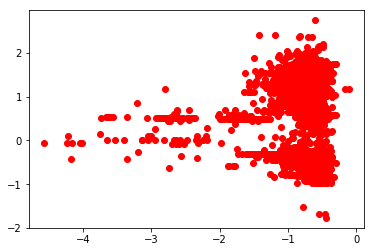

IS_SHARPE TO MIN RATIO 45 OOS_PROFITABILITY


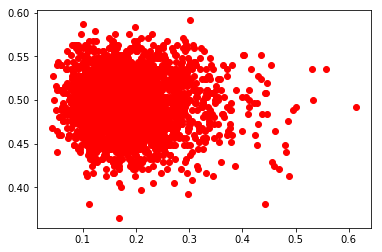

IS_SHARPE TO MIN RATIO 45 OOS_SHARPE DIFFERENCE SLIPPAGE


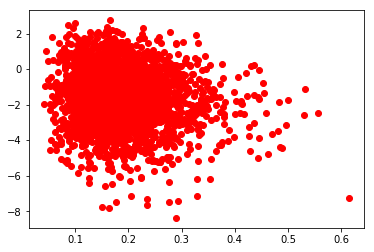

IS_SHARPE TO MIN RATIO 45 OOS_SHARPE


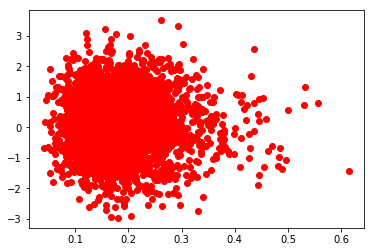

IS_SHARPE TO MIN RATIO 45 OOS_BETA


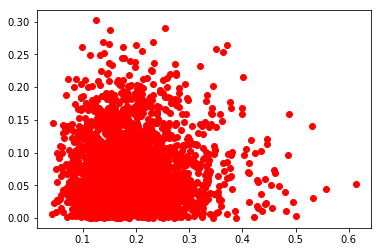

IS_SHARPE TO MIN RATIO 45 OOS_ANNUALIZED RETURN


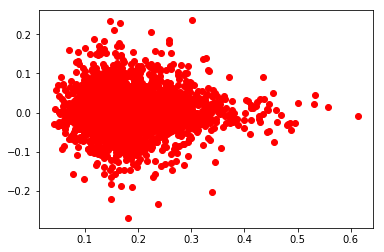

IS_SHARPE TO MIN RATIO 45 OOS_FACTOR SHARPE


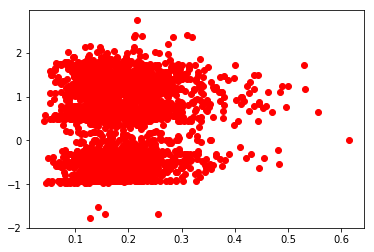

IS_SHARPE TO MIN RATIO 90 OOS_PROFITABILITY


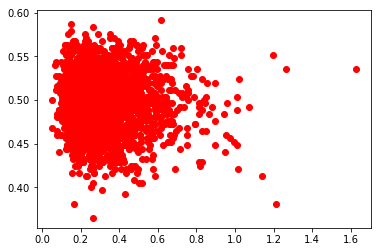

IS_SHARPE TO MIN RATIO 90 OOS_SHARPE DIFFERENCE SLIPPAGE


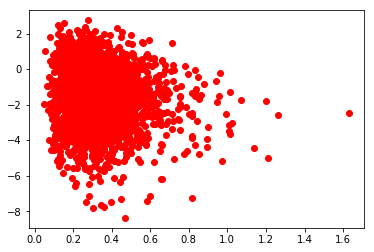

IS_SHARPE TO MIN RATIO 90 OOS_SHARPE


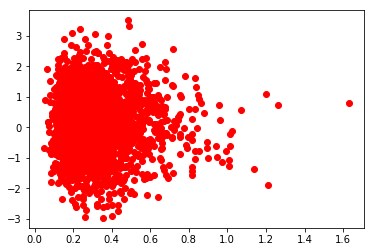

IS_SHARPE TO MIN RATIO 90 OOS_BETA


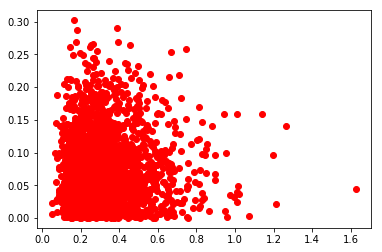

IS_SHARPE TO MIN RATIO 90 OOS_ANNUALIZED RETURN


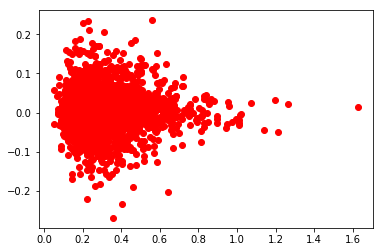

IS_SHARPE TO MIN RATIO 90 OOS_FACTOR SHARPE


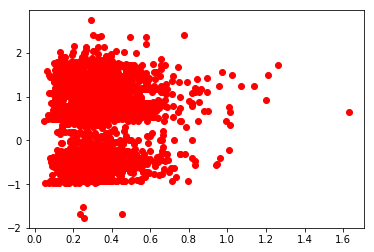

IS_SMART INFORMATION RATIO OOS_PROFITABILITY


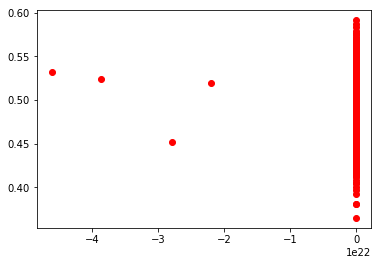

IS_SMART INFORMATION RATIO OOS_SHARPE DIFFERENCE SLIPPAGE


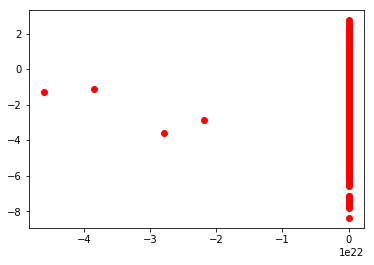

IS_SMART INFORMATION RATIO OOS_SHARPE


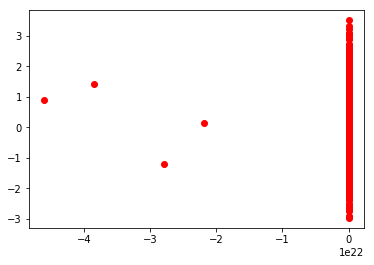

IS_SMART INFORMATION RATIO OOS_BETA


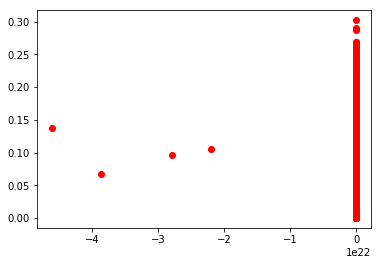

IS_SMART INFORMATION RATIO OOS_ANNUALIZED RETURN


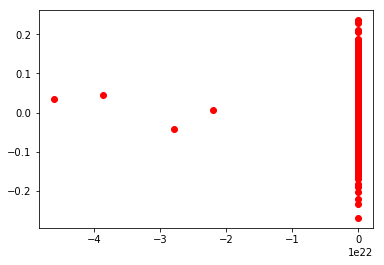

IS_SMART INFORMATION RATIO OOS_FACTOR SHARPE


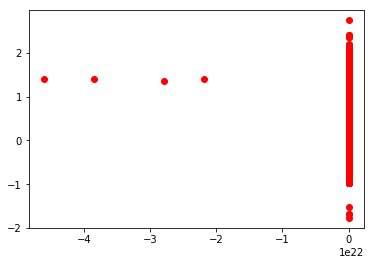

IS_STABILITY OOS_PROFITABILITY


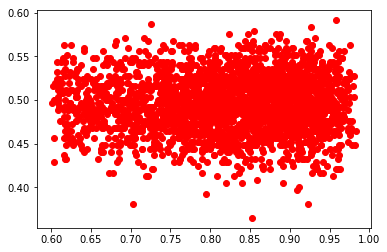

IS_STABILITY OOS_SHARPE DIFFERENCE SLIPPAGE


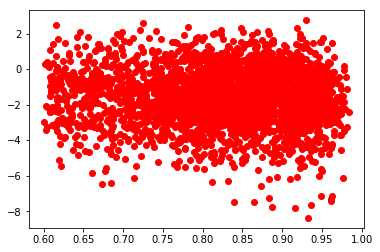

IS_STABILITY OOS_SHARPE


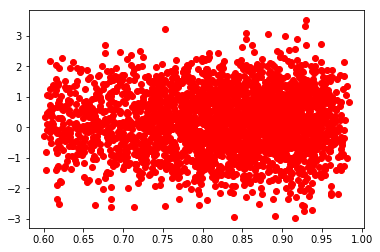

IS_STABILITY OOS_BETA


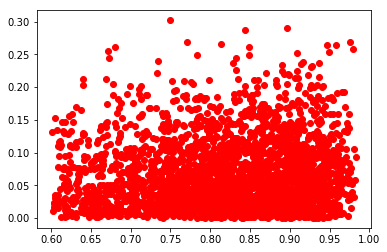

IS_STABILITY OOS_ANNUALIZED RETURN


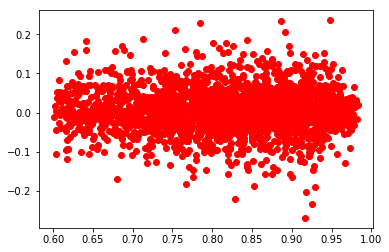

IS_STABILITY OOS_FACTOR SHARPE


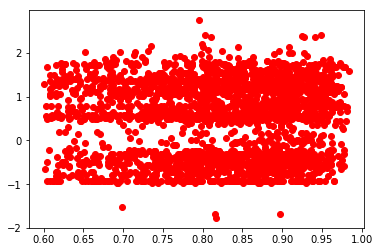

IS_TOTAL DAYS SEEN OOS_PROFITABILITY


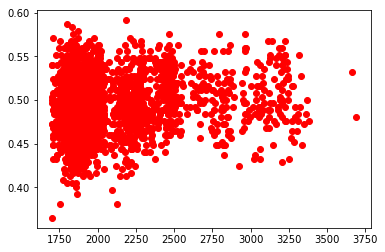

IS_TOTAL DAYS SEEN OOS_SHARPE DIFFERENCE SLIPPAGE


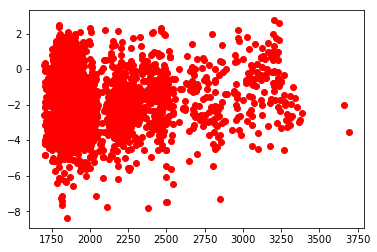

IS_TOTAL DAYS SEEN OOS_SHARPE


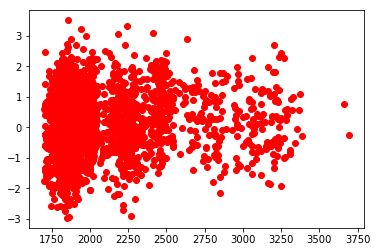

IS_TOTAL DAYS SEEN OOS_BETA


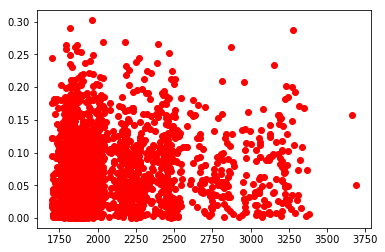

IS_TOTAL DAYS SEEN OOS_ANNUALIZED RETURN


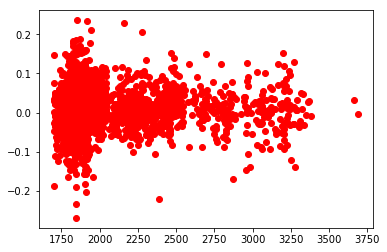

IS_TOTAL DAYS SEEN OOS_FACTOR SHARPE


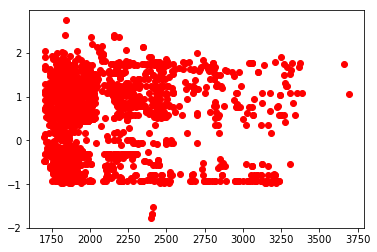

IS_TREYNOR OOS_PROFITABILITY


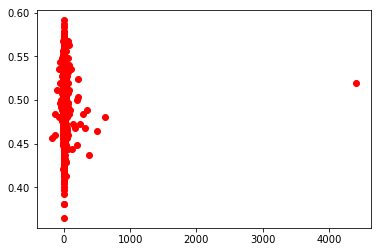

IS_TREYNOR OOS_SHARPE DIFFERENCE SLIPPAGE


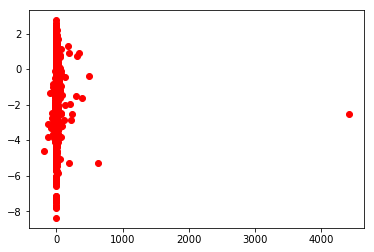

IS_TREYNOR OOS_SHARPE


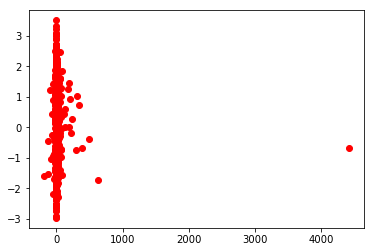

IS_TREYNOR OOS_BETA


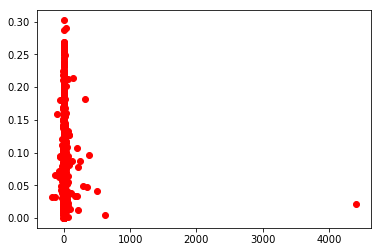

IS_TREYNOR OOS_ANNUALIZED RETURN


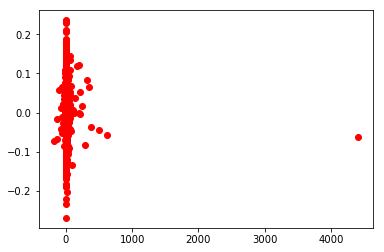

IS_TREYNOR OOS_FACTOR SHARPE


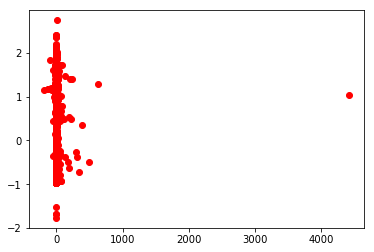

OOS_ANNUALIZED RETURN OOS_PROFITABILITY


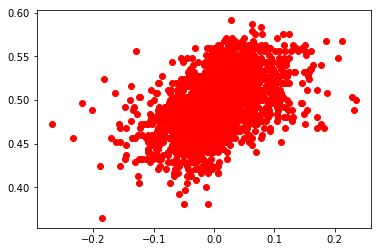

OOS_ANNUALIZED RETURN OOS_SHARPE DIFFERENCE SLIPPAGE


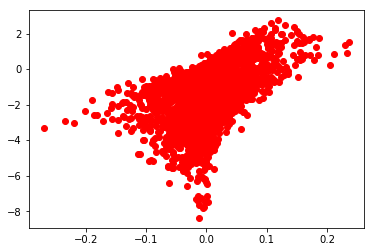

OOS_ANNUALIZED RETURN OOS_SHARPE


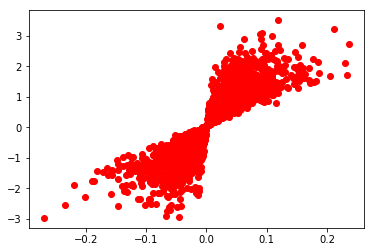

OOS_ANNUALIZED RETURN OOS_BETA


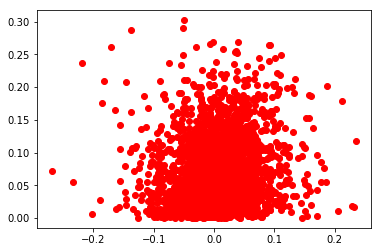

OOS_ANNUALIZED RETURN OOS_ANNUALIZED RETURN


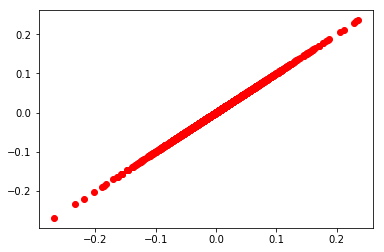

OOS_ANNUALIZED RETURN OOS_FACTOR SHARPE


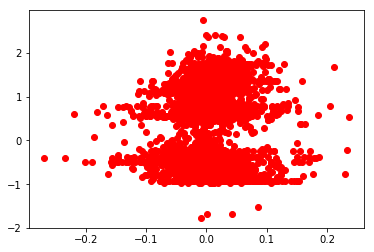

OOS_BETA OOS_PROFITABILITY


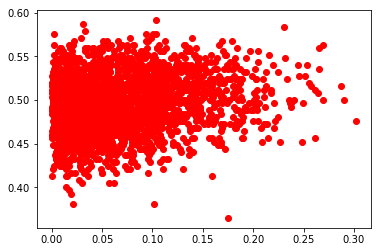

OOS_BETA OOS_SHARPE DIFFERENCE SLIPPAGE


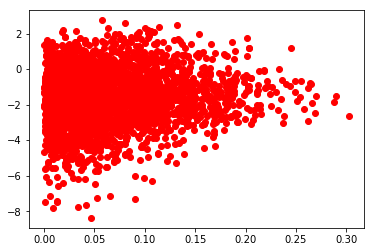

OOS_BETA OOS_SHARPE


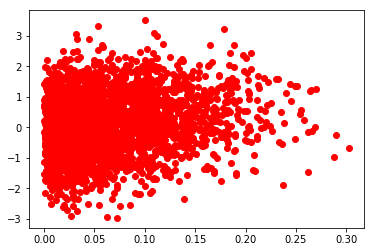

OOS_BETA OOS_BETA


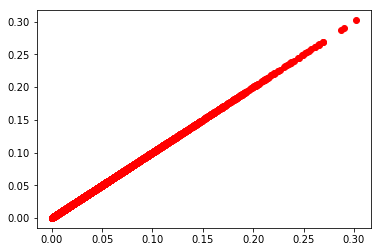

OOS_BETA OOS_ANNUALIZED RETURN


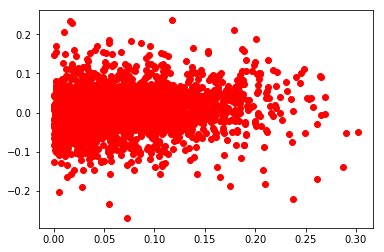

OOS_BETA OOS_FACTOR SHARPE


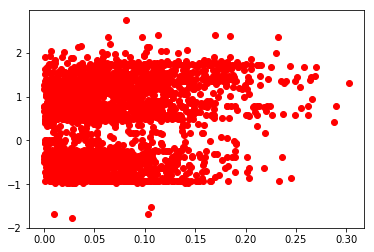

OOS_FACTOR SHARPE OOS_PROFITABILITY


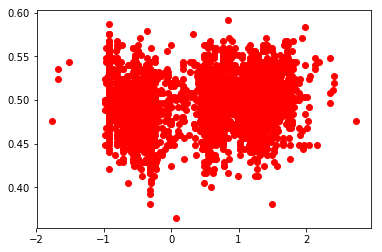

OOS_FACTOR SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


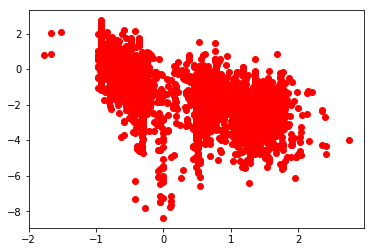

OOS_FACTOR SHARPE OOS_SHARPE


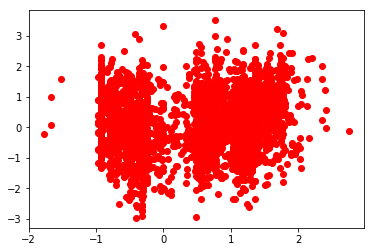

OOS_FACTOR SHARPE OOS_BETA


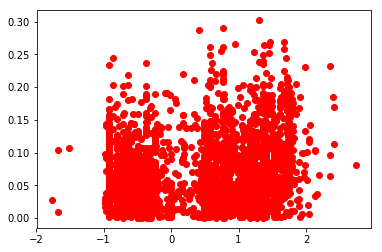

OOS_FACTOR SHARPE OOS_ANNUALIZED RETURN


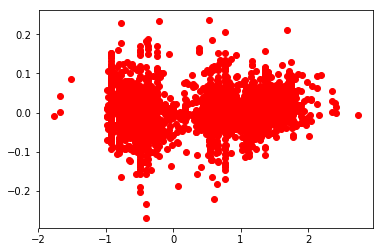

OOS_FACTOR SHARPE OOS_FACTOR SHARPE


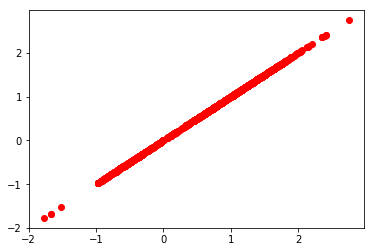

OOS_PROFITABILITY OOS_PROFITABILITY


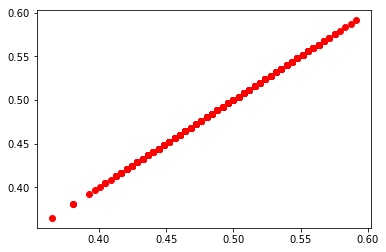

OOS_PROFITABILITY OOS_SHARPE DIFFERENCE SLIPPAGE


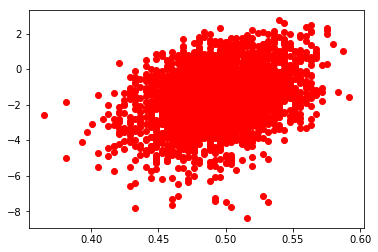

OOS_PROFITABILITY OOS_SHARPE


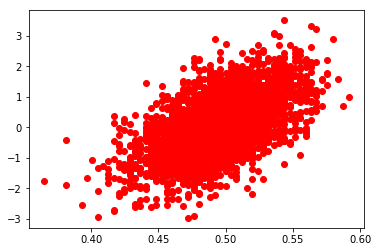

OOS_PROFITABILITY OOS_BETA


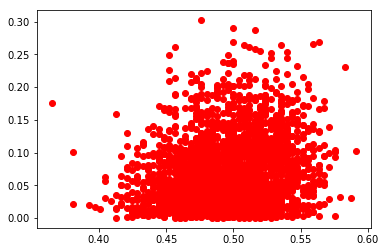

OOS_PROFITABILITY OOS_ANNUALIZED RETURN


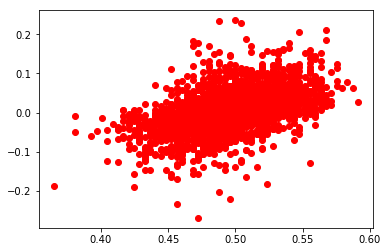

OOS_PROFITABILITY OOS_FACTOR SHARPE


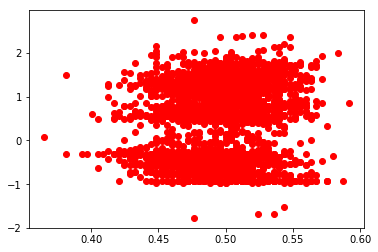

OOS_RAW BETA OOS_PROFITABILITY


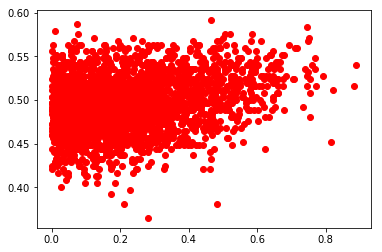

OOS_RAW BETA OOS_SHARPE DIFFERENCE SLIPPAGE


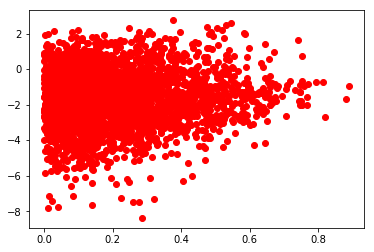

OOS_RAW BETA OOS_SHARPE


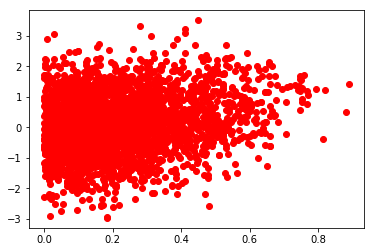

OOS_RAW BETA OOS_BETA


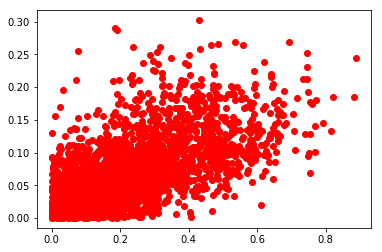

OOS_RAW BETA OOS_ANNUALIZED RETURN


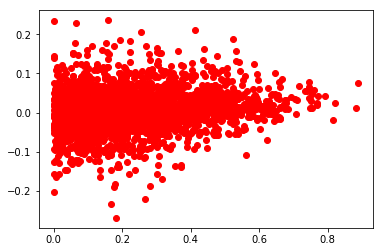

OOS_RAW BETA OOS_FACTOR SHARPE


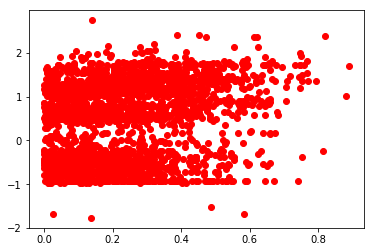

OOS_SHARPE OOS_PROFITABILITY


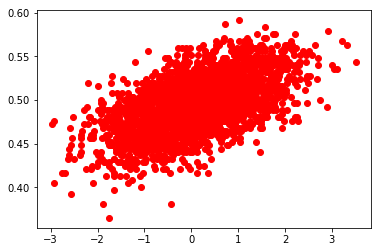

OOS_SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


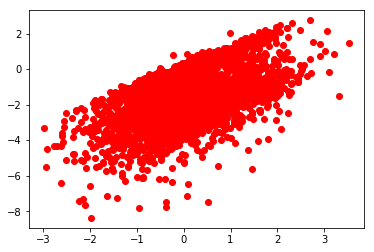

OOS_SHARPE OOS_SHARPE


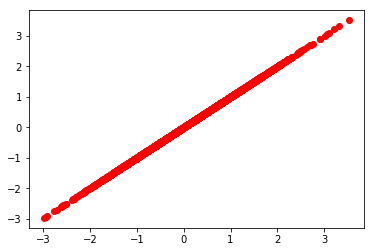

OOS_SHARPE OOS_BETA


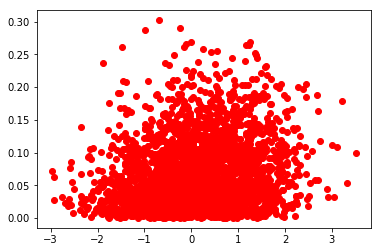

OOS_SHARPE OOS_ANNUALIZED RETURN


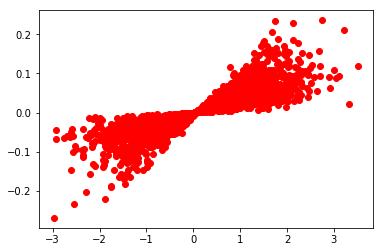

OOS_SHARPE OOS_FACTOR SHARPE


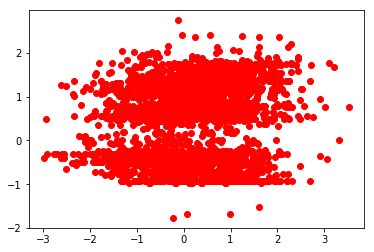

OOS_SHARPE DIFFERENCE SLIPPAGE OOS_PROFITABILITY


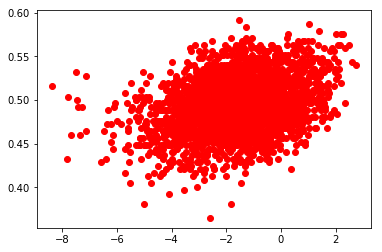

OOS_SHARPE DIFFERENCE SLIPPAGE OOS_SHARPE DIFFERENCE SLIPPAGE


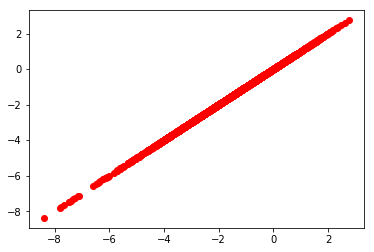

OOS_SHARPE DIFFERENCE SLIPPAGE OOS_SHARPE


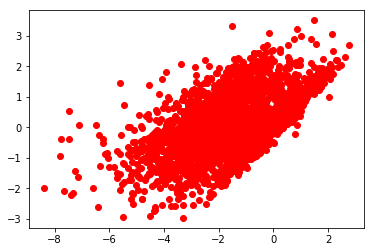

OOS_SHARPE DIFFERENCE SLIPPAGE OOS_BETA


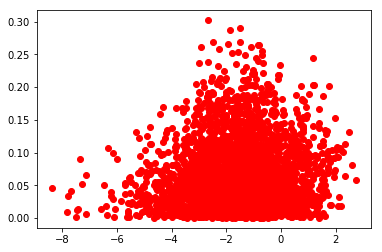

OOS_SHARPE DIFFERENCE SLIPPAGE OOS_ANNUALIZED RETURN


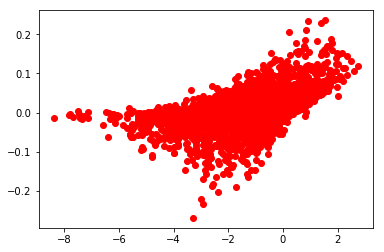

OOS_SHARPE DIFFERENCE SLIPPAGE OOS_FACTOR SHARPE


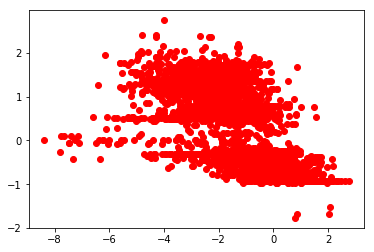

model OOS_PROFITABILITY
numberOfPredictors
2    0.495357
Name: OOS_PROFITABILITY, dtype: float64
numberOfPredictors
2   -1.613401
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
numberOfPredictors
2    0.140908
Name: OOS_SHARPE, dtype: float64
numberOfPredictors OOS_PROFITABILITY


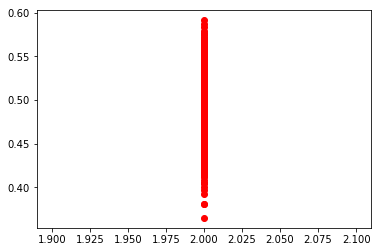

numberOfPredictors OOS_SHARPE DIFFERENCE SLIPPAGE


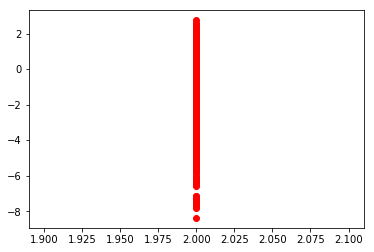

numberOfPredictors OOS_SHARPE


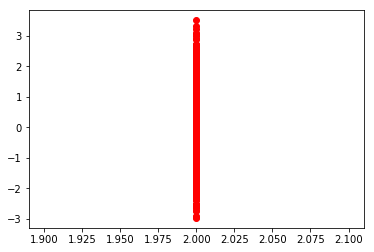

numberOfPredictors OOS_BETA


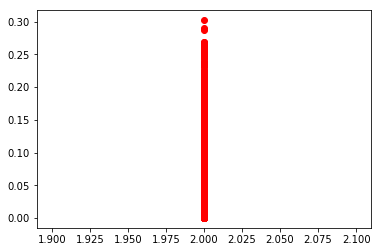

numberOfPredictors OOS_ANNUALIZED RETURN


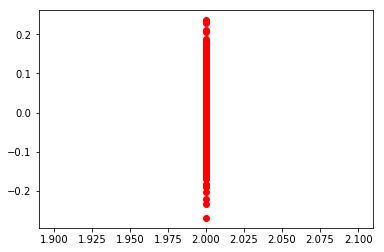

numberOfPredictors OOS_FACTOR SHARPE


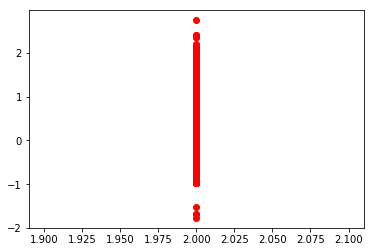

predictionLength
2    0.483669
3    0.494107
5    0.496347
Name: OOS_PROFITABILITY, dtype: float64
predictionLength
2   -2.776519
3   -2.030308
5   -1.398397
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
predictionLength
2   -0.035421
3    0.078189
5    0.173309
Name: OOS_SHARPE, dtype: float64
predictionLength OOS_PROFITABILITY


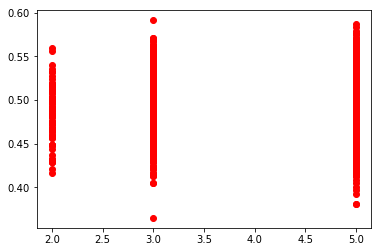

predictionLength OOS_SHARPE DIFFERENCE SLIPPAGE


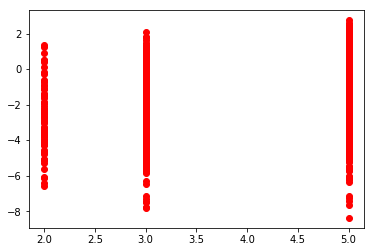

predictionLength OOS_SHARPE


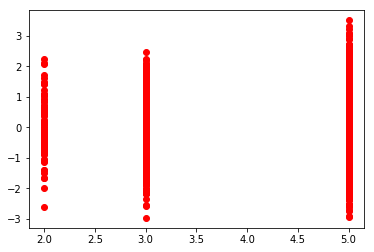

predictionLength OOS_BETA


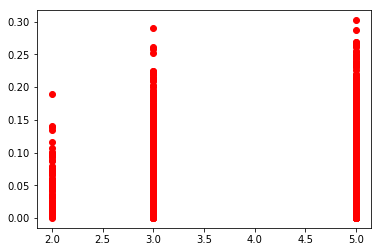

predictionLength OOS_ANNUALIZED RETURN


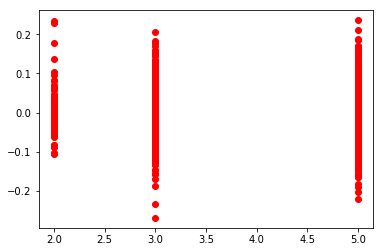

predictionLength OOS_FACTOR SHARPE


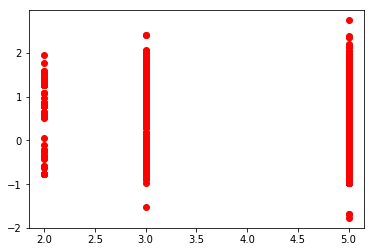

ticker OOS_PROFITABILITY


In [47]:
cm = pd.DataFrame(cleanedModels)
for col in cm.columns.values:
    
    try:
        import matplotlib.pyplot as plt
        groupsSharpe = cm.groupby([col])["OOS_PROFITABILITY"].mean()
        if len(groupsSharpe) < 20:
            print(groupsSharpe)
            print(cm.groupby([col])["OOS_SHARPE DIFFERENCE SLIPPAGE"].mean())
            print(cm.groupby([col])["OOS_SHARPE"].mean())
        print(col, "OOS_PROFITABILITY")
        xVals = cm[[col]].values
        yVals = cm[["OOS_PROFITABILITY"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        print(col, "OOS_SHARPE DIFFERENCE SLIPPAGE")
        xVals = cm[[col]].values
        yVals = cm[["OOS_SHARPE DIFFERENCE SLIPPAGE"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        
        print(col, "OOS_SHARPE")
        xVals = cm[[col]].values
        yVals = cm[["OOS_SHARPE"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        
        print(col, "OOS_BETA")
        xVals = cm[[col]].values
        yVals = cm[["OOS_BETA"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        
        print(col, "OOS_ANNUALIZED RETURN")
        xVals = cm[[col]].values
        yVals = cm[["OOS_ANNUALIZED RETURN"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        
        print(col, "OOS_FACTOR SHARPE")
        xVals = cm[[col]].values
        yVals = cm[["OOS_FACTOR SHARPE"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        plt.draw()
    except:
        continue
    



In [193]:
cm = pd.DataFrame(cleanedModels).dropna()
cmInput = cm[list(set(cm.columns.values) - set(["OOS_SHARPE DIFFERENCE", "IS_FACTOR SHARPE", "IS_RAW BETA",  "OOS_SHARPE", "OOS_SHARPE SLIPPAGE", "combiner", "ticker"]))]
cmOutput = cm[["OOS_SHARPE DIFFERENCE"]]

In [194]:
cmInput.columns

Index(['IS_EXTREME STABILITY', 'IS_ALPHA SLIPPAGE',
       'IS_25TH PERCENTILE SHARPE DIFFERENCE',
       'IS_RELATIVE SHARPE DIFFERENCE AVERAGE', 'IS_SHARPE', 'IS_TREYNOR',
       'numberOfPredictors', 'IS_SHARPE SLIPPAGE', 'IS_ANNUALIZED RETURN',
       'IS_TOTAL DAYS SEEN', 'IS_ROLLING SHARPE STABILITY',
       'IS_RELATIVE SHARPE', 'IS_SHARPE DIFFERENCE MIN',
       'IS_SMART INFORMATION RATIO', 'IS_ONE STD SHARPE',
       'IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE',
       'IS_SHARPE DIFFERENCE SLIPPAGE', 'IS_SHARPE SLIPPAGE DECAY', 'IS_BETA',
       'IS_ACTIVITY', 'IS_25TH PERCENTILE SHARPE', 'predictionLength',
       'IS_STABILITY', 'IS_SHARPE DIFFERENCE AVERAGE', 'IS_SHARPE DIFFERENCE',
       'IS_RELATIVE SHARPE SLIPPAGE',
       'IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0',
       'IS_ROLLING SHARPE BETA', 'IS_SHARPE DIFFERENCE GREATER THAN 0',
       'IS_EXTREME STABILITY ROLLING 600', 'IS_ALPHA',
       'IS_RELATIVE SHARPE DIFFERENCE MIN', 'IS_ROLLING SHARPE ERROR',


In [195]:
cmInput

IS_EXTREME STABILITY  IS_ALPHA SLIPPAGE  \
0                 0.894353           0.024758   
1                 0.831139           0.006916   
2                 0.948945           0.013766   
3                 0.900520           0.030273   
4                 0.568942          -0.033652   
5                 0.966962          -0.125269   
6                 0.900418          -0.005503   
7                 0.830910           0.025786   
8                 0.885403          -0.072214   
9                 0.578649          -0.141544   
10                0.906195          -0.093420   
11                0.923875          -0.015772   
12                0.943938           0.017491   
13                0.941729          -0.005539   
14                0.916089          -0.063615   
15                0.790493          -0.005384   
16                0.871827          -0.018051   
17                0.903407          -0.017845   
18                0.988059          -0.086671   
19                0.942772          -0.104427   
20                0.238429          -0.062250   
21                0.914889          -0.000029   
22                0.927985           0.021460   
23                0.911500          -0.028886   
24                0.973613           0.030547   
25                0.922506          -0.010017   
26                0.906655          -0.050727   
27                0.871612           0.001390   
28                0.953608           0.006605   
29                0.941923          -0.106208   
...                    ...                ...   
985               0.939974          -0.055073   
986               0.840837          -0.047111   
987               0.893866           0.004992   
988               0.947402          -0.005701   
989               0.880395          -0.094314   
990               0.977618          -0.029909   
991               0.879512           0.038575   
992               0.964554          -0.036370   
993               0.869982           0.080566   
994               0.929784           0.028701   
995               0.922783           0.003670   
996               0.951511          -0.004893   
997               0.954676          -0.034455   
998               0.936643           0.018279   
999               0.926000           0.003218   
1000              0.983928           0.005881   
1001              0.951241           0.003815   
1002              0.793543          -0.023928   
1003              0.930301          -0.019865   
1004              0.953109          -0.000536   
1005              0.700821           0.034337   
1006              0.944626          -0.037619   
1007              0.962389           0.007852   
1008              0.842233           0.025145   
1009              0.946502           0.027457   
1010              0.851657          -0.016908   
1011              0.969881           0.003821   
1012              0.922469          -0.059554   
1013              0.938384           0.006544   
1014              0.950080           0.018864   

      IS_25TH PERCENTILE SHARPE DIFFERENCE  \
0                                 0.175650   
1                                -0.695773   
2                                -0.251761   
3                                 0.188593   
4                                -1.167552   
5                                -0.560736   
6                                -0.856553   
7                                -0.467776   
8                                -0.667763   
9                                -0.777884   
10                               -0.504495   
11                               -0.611497   
12                               -0.084047   
13                                0.263290   
14                               -0.594040   
15                               -0.312210   
16                               -0.197207   
17                               -1.196871   
18                               -0.994772   
19                               -0.785448   
2

In [196]:
len(cmOutput[cmOutput > 0].dropna())/len(cmOutput.dropna())

0.3185404339250493

In [197]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [207]:
cmOutput

OOS_SHARPE DIFFERENCE
0                 -0.389076
1                 -0.555811
2                  0.639304
3                 -0.084324
4                  0.130381
5                 -0.179134
6                 -0.011525
7                 -0.173473
8                 -0.221728
9                  1.328103
10                -0.307729
11                -0.476871
12                -1.241450
13                -0.456533
14                 0.466924
15                 0.298828
16                -0.245713
17                -0.600989
18                 0.713753
19                -1.003619
20                -0.589400
21                 0.526963
22                -0.628756
23                -0.443001
24                -2.392421
25                -0.063517
26                 0.008942
27                -0.783733
28                -0.141420
29                 0.186789
...                     ...
985               -0.256159
986                0.940811
987               -1.569646
988                0.389910
989               -0.012205
990               -0.123618
991               -0.160242
992               -0.461083
993                0.630413
994                0.372525
995               -0.211621
996               -0.805760
997                0.397000
998                0.015404
999               -1.464076
1000              -0.643657
1001              -0.629181
1002              -1.295132
1003               0.551519
1004              -0.670014
1005               0.055733
1006              -0.454585
1007              -0.252837
1008              -1.664751
1009              -0.454983
1010               0.687247
1011               0.601542
1012              -0.538446
1013              -0.706828
1014               0.000000

[1014 rows x 1 columns]

In [203]:
dtreg = DecisionTreeRegressor(min_samples_leaf=30).fit(cmInput[:750], cmOutput[:750])

In [204]:
tree.export_graphviz(dtreg, out_file='tree.dot')

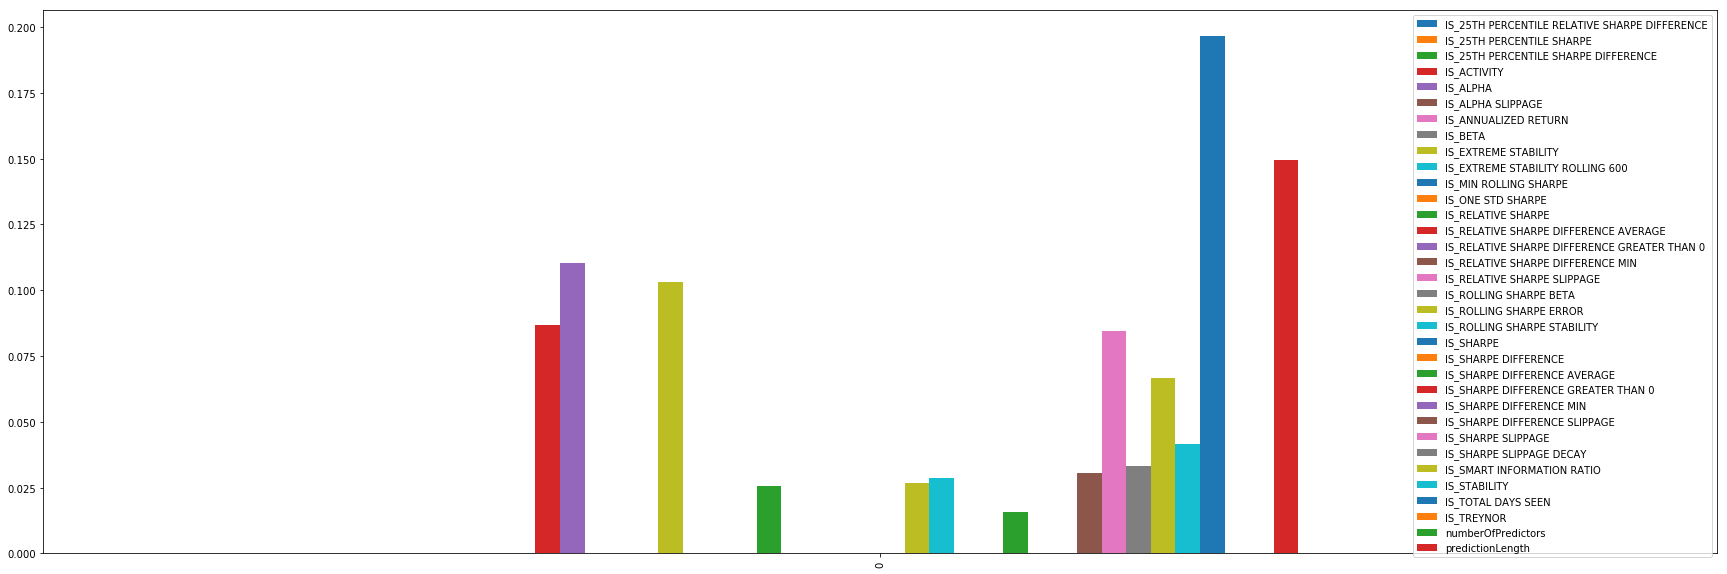

In [205]:
mapper = {}
for i in range(len(cmInput.columns)):
    mapper[cmInput.columns[i]] = dtreg.feature_importances_[i]
%matplotlib inline
pd.DataFrame([mapper]).plot.bar(figsize=(30,10))

In [208]:
pd.DataFrame(dtreg.predict(cmInput[750:]), index=cmOutput[750:].index, columns=["Predicted OOS_SHARPE DIFFERENCE"]).join(cmOutput[750:])

Predicted OOS_SHARPE DIFFERENCE  OOS_SHARPE DIFFERENCE
751                         -0.985127              -0.093945
752                          0.239407               0.511387
753                          0.239407               0.324767
754                         -0.008772               0.716352
755                         -0.423803               0.332160
756                          0.078780               0.571654
757                         -0.389904               0.338736
758                         -0.985127              -1.035398
759                          0.015560               0.228423
760                         -1.334179              -1.683748
761                         -0.191146              -1.282774
762                          0.239407               0.325572
763                         -0.423803              -0.512061
764                          0.078780              -0.275203
765                         -0.423803              -1.096408
766                         -0.498985              -1.284157
767                         -0.008772               0.439739
768                          0.239407              -0.868805
769                         -0.057781              -0.912292
770                         -0.389904              -0.435862
771                         -0.498985              -0.237537
772                         -0.321869               0.358073
773                         -0.321869              -1.607202
774                         -0.191146              -3.017713
775                         -0.634383              -0.135962
776                         -0.008772              -0.021297
777                         -0.601651              -0.063556
778                         -1.334179              -1.317508
779                         -0.985127              -0.832299
780                         -0.464562               1.430417
...                               ...                    ...
985                         -0.449078              -0.256159
986                         -0.498985               0.940811
987                         -0.464562              -1.569646
988                          0.078780               0.389910
989                         -0.321869              -0.012205
990                          0.196754              -0.123618
991                         -0.620752              -0.160242
992                         -0.536706              -0.461083
993                          0.239407               0.630413
994                         -0.423803               0.372525
995                         -0.057781              -0.211621
996                         -0.536706              -0.805760
997                         -0.057781               0.397000
998                          0.239407               0.015404
999                         -0.389904              -1.464076
1000                        -0.191146              -0.643657
1001                        -0.057781              -0.629181
1002                        -0.498985              -1.295132
1003                         0.078780               0.551519
1004                         0.196754              -0.670014
1005                        -0.191146               0.055733
1006                         0.015560              -0.454585
1007                        -0.536706              -0.252837
1008                        -0.634383              -1.664751
1009                         0.078780              -0.454983
1010                         0.196754               0.687247
1011                        -0.536706               0.601542
1012                        -0.464562              -0.538446
1013                         0.015560              -0.706828
1014                        -0.191146               0.000000

[264 rows x 2 columns]